In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid",{'xtick.top': True, 'ytick.right': True,'xtick.bottom': True, 'ytick.left': True,'grid.linestyle': '--','image.cmap': 'viridis','xtick.direction': 'in',
 'ytick.direction': 'in'})

# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'


# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


In [3]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [79]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'e', 'p', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        print(offset, name)
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 7],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['sj-orbit-s']:os['sj-orbit-e']],'sj-orbit-') )
    dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic


In [75]:

def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    #dic.update({'ejection_{'+planet_name+'}':ejection})

    #return dic
    
def post_process(fname, os, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    print(star_name, planet_name, star_pairs)
    
    data = load_data(fname, os, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data


In [80]:
prefix = '../code/phase-map/mono/'

mono_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':45, 'closest-s':45,'closest-e':63}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
single_1 = pd.DataFrame(post_process(prefix+'revision-mono-single.txt', mono_single_idx, names, pairs))


['s', 's1'] ['j'] [('s', 's1')]
0 s
10 j
20 s1


/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/yihan/anaconda3/lib/python3.6/site-

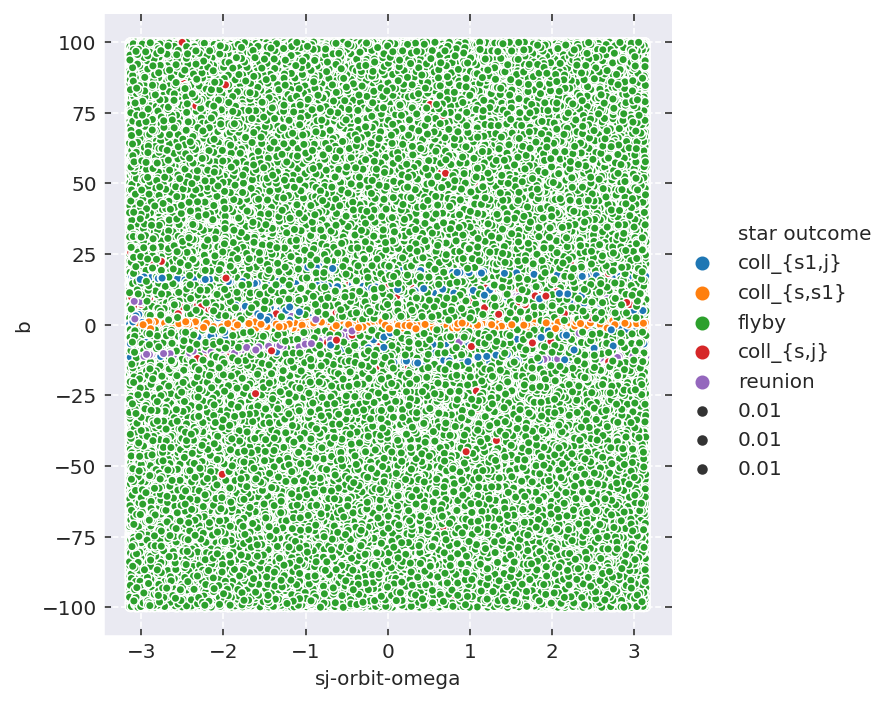

In [87]:
sns.relplot(data=single_1,x='sj-orbit-omega',y='b',hue='star outcome',size=0.01)

In [650]:
multi_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'sn-orbit-s' : 9, 'sn-orbit-e':17, 'incident-s':17, 'incident-e':22, 'post-s':22, 'post-e':63,'closest-s':63,'closest-e':87}

names = ['s', 'j', 'n', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j'), ('s','n'), ('s1','n')]
    
multi_single = post_process(prefix+'revision-multi-single.txt', multi_single_idx, names, pairs)

['s', 's1'] ['j', 'n'] [('s', 's1')]
0 s
10 j
20 n
30 s1


/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages

In [640]:
mono_binary_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9,'ss-orbit-s':9,'ss-orbit-e':17, 'incident-s':17, 'incident-e':22, 'post-s':22, 'post-e':63,'closest-s':63,'closest-e':87}

names = ['s','j', 's1', 's2']

pairs = [('s','j'), ('s','s1'), ('s','s2'), ('s1','j'), ('s2','j'), ('s1','s2')]

binary_1 = post_process(prefix+'revision-mono-binary.txt', mono_binary_idx, names, pairs)

['s', 's1', 's2'] ['j'] [('s', 's1'), ('s', 's2'), ('s1', 's2')]
0 s
10 j
20 s1
30 s2


/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages

In [58]:
binary_10 = post_process(prefix+'binary_10.txt', mono_binary_idx, names, pairs)
binary_50 = post_process(prefix+'binary_50.txt', mono_binary_idx, names, pairs)

['s', 's1', 's2'] ['j'] [('s', 's1'), ('s', 's2'), ('s1', 's2')]
0 s
10 j
20 s1
30 s2


/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages

['s', 's1', 's2'] ['j'] [('s', 's1'), ('s', 's2'), ('s1', 's2')]
0 s
10 j
20 s1
30 s2


In [6]:
import matplotlib.ticker as mticker
from scipy.interpolate import interp2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def func_format(x, pos):
    fmt = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    if int(x) == x:
        return "${}$".format(fmt._formatSciNotation('%1.1e' % 10**x))
    else:
        return ""
    
def draw_dist_2d(ax,x_dat, y_dat, x_label, y_label, clabel, color1d, bins=10, size1d=.45,w=None,density=True):
    
    den,x,y  = np.histogram2d(x_dat, y_dat, bins=bins,weights=w,normed=density)
    x_c = 0.5*(x[1::]+x[0:-1])
    y_c = 0.5*(y[1::]+y[0:-1])
    f = interp2d(x_c, y_c, den.transpose(), kind='linear')
    
    x_new = np.linspace(x.min(),x.max(),30,endpoint=True)
    y_new = np.linspace(y.min(),y.max(),30,endpoint=True)
    den_new = (f(x_new,y_new))
    
    x_grid, y_grid = np.meshgrid(x_new,y_new)
    CS=ax.contourf((x_grid),(y_grid),den_new,30,alpha=1,cmap='viridis')
    CS2=ax.contour((x_grid),(y_grid),den_new,30,linewidths=0.3,cmap='viridis')
    #plt.clabel(CS2, CS2.levels[::2], inline=1, colors='k', fontsize=5)

    cbar = plt.colorbar(CS,ax=ax)
    cbar.set_label(clabel)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", size1d, pad=0.1, sharex=ax)
    axHisty = divider.append_axes("right", size1d, pad=0.1, sharey=ax)

    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft  =False)
    
    sbins = bins
    
    _, xbin = np.histogram(x_dat,bins=sbins,normed=density)
    axHistx.hist(x_dat, bins=xbin, normed=density, weights=w, histtype='step',color=color1d,lw=.5)
    axHistx.hist(x_dat, bins=xbin, normed=density, weights=w, histtype='stepfilled',alpha=0.3,color=color1d)
    
    _, ybin = np.histogram(y_dat,bins=sbins,normed=density)
    axHisty.hist(y_dat, bins=ybin,normed=density, weights=w, orientation='horizontal',histtype='step',color=color1d,lw=0.5)
    axHisty.hist(y_dat, bins=ybin,normed=density, weights=w, orientation='horizontal',histtype='stepfilled',alpha=.3,color=color1d)
    
    axHistx.autoscale(enable=True, axis='x', tight=True)
    axHisty.autoscale(enable=True, axis='y', tight=True)
    ax.autoscale(enable=True, axis='xy', tight=True)

    return ax, axHistx, axHisty, f

def create_side_axis(ax, size1d = 0.4):
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", size1d, pad=0.1, sharex=ax)
    axHisty = divider.append_axes("right", size1d, pad=0.1, sharey=ax)
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft  =False)
    
    return axHistx, axHisty

def draw_scatter_2d(ax, x_dat, y_dat, colors, markers, sz, xbins=15, ybins=15,size1d=.4, xden=False,yden=False):
    
    axHistx, axHisty = create_side_axis(ax, size1d)
    
    for x, y, color, marker in zip(x_dat, y_dat, colors, markers):
        ax.scatter(x, y, s=sz, color=color,lw=0)
        
        axHistx.hist(x, bins=xbins, normed=xden, histtype='step',color=color,lw=.5)
        axHistx.hist(x, bins=xbins, normed=xden, histtype='stepfilled',alpha=0.3,color=color)
        
        axHisty.hist(y, bins=ybins,normed=yden, orientation='horizontal',histtype='step',color=color,lw=0.5)
        axHisty.hist(y, bins=ybins,normed=yden, orientation='horizontal',histtype='stepfilled',alpha=.3,color=color)
    
        axHistx.autoscale(enable=True, axis='x', tight=True)
        axHisty.autoscale(enable=True, axis='y', tight=True)
        ax.autoscale(enable=True, axis='xy', tight=True)
        axHistx.set_yscale('log')
        axHisty.set_xscale('log')
    return ax, axHistx, axHisty

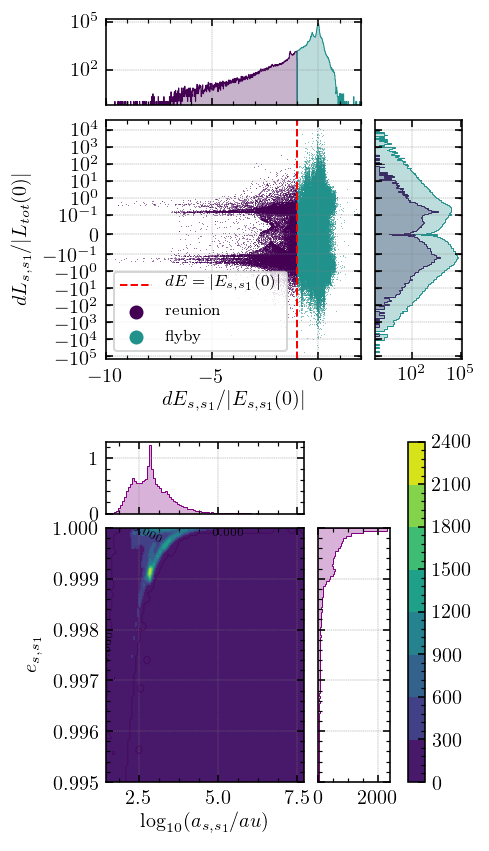

In [53]:
def show_single_star_EL(out):
    b = out['b']
    v0 = out['v_inf']
    ms = out['m_{s}']
    mj = out['m_{j}']
    ms1 =out['m_{s1}']
    
    
    
    u = (ms+mj) * ms1/(ms+mj + ms1)
    E_s0 = 0.5*u*v0**2 - G*ms*ms1/ np.sqrt((400*AU)**2 + b**2)
    L_s0 = ms1 * v0 * b
    L_j0 = mj*ms/(mj+ms)*np.sqrt(G*(ms+mj)*1*AU)
    
    E_std = E_s0[0]
    L_std = abs(L_s0 + L_j0)
    
    ps = out['p_{s}']
    vs = out['v_{s}']
    ps1 = out['p_{s1}']
    vs1 = out['v_{s1}']
    
    E_s = 0.5*ms*((vs)**2).sum(axis=1) + 0.5*ms1*((vs1)**2).sum(axis=1) - G*ms*ms1/ np.sqrt(((ps - ps1)**2).sum(axis=1))
    L_s = np.array([ms1,]*3).transpose()*cross(ps1-ps,vs1-vs) #+ np.array([ms1,]*3).transpose()*cross(ps1,vs1)#u* np.sqrt(G*(ms+ms1)*a_s*(1 - e_s*e_s))
    L_s = L_s[:,2]
    
    dE = E_s - E_s0
    dL = L_s - L_s0
    
    coll_ss = out['coll_{s,s1}']
    coll_js = out['coll_{s1,j}'] | out['coll_{s,j}']
    coll =  coll_ss | coll_js

    cut = ~coll & (-20<b)&(b<30)
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    sz=0.1
    colors = cm.viridis(np.linspace(0,1,3))
    
    fig = plt.figure(figsize=(3.5,6))
    ax = fig.add_subplot(2,1,1)
    
    labels=['reunion', 'flyby']
    for color, label in zip(colors, labels):
        ax.scatter([],[],color=color,label=label)
        
    dL/=L_std
    
    ybin =np.concatenate((-10**np.linspace(5,-3,100),10**np.linspace(-3,4,200)))
    ax, axHistx, axHisty = draw_scatter_2d(ax, [dE[reunion]/E_std, dE[flyby]/E_std],[dL[reunion], dL[flyby]], colors, ['.','.'], sz, np.linspace(-10, 3, 1000),ybin, 0.6, False)
    
    ax.set_xlim(-10,2)

    ax.set_yscale('symlog',linthreshy=.1)
    axHisty.set_yscale('symlog',linthreshy=.1)

    
    ax.axvline(-1,ls='--',color='red',label='$dE = |E_{s,s_1}(0)|$',lw=1)
    ax.legend(fontsize=8)
    ax.set_xlabel('$dE_{s,s_1}/|E_{s,s_1}(0)|$')
    ax.set_ylabel('$dL_{s,s_1}/|L_{tot}(0)|$')

    
    ax = fig.add_subplot(2,1,2)
    a_s = out['a_{s,s1}']
    e_s = out['e_{s,s1}']
    draw_dist_2d(ax,np.log10(a_s[reunion&(e_s>0.995)]/AU), e_s[reunion&(e_s>0.995)], '$\log_{10}(a_{s,s_1}/au)$', '$e_{s,s_1}$', '', 'purple', 100, 0.5)
    
    plt.tight_layout()
    savefig(plt,'single-star-EL','.png','.png')
show_single_star_EL(single_1) 


In [34]:
def show_single_planet_EL(ax, name, out, events, colors_in, labels):
    b = out['b']
    v0 = out['v_inf']
    ms = out['m_{s}']
    mj = out['m_{j}']
    ms1 =out['m_{s1}']
    
    u_sj = (ms+mj) * ms1/(ms+mj + ms1)
    u = (ms+mj) * ms1/(ms+mj + ms1)
    
    
    a_sj0 = 1*AU 
    
    E_ss10 = 0.5*u*v0**2 - G*ms*ms1/ np.sqrt((400*AU)**2 + b**2)
    
    E_sj0 = -0.5*G*ms*mj/a_sj0
    L_sj0 = mj*np.sqrt(G*ms*a_sj0)#u_sj*np.sqrt(G*(ms+mj)*a_sj0)
    
    
    E_std = abs(E_sj0[0])
    L_std = abs(L_sj0[0])
    
    ps = out['p_{s}']
    vs = out['v_{s}']
    pj = out['p_{j}']
    vj = out['v_{j}']

    E_sj = 0.5*mj*((vj-vs)**2).sum(axis=1) - G*ms*mj/ np.sqrt(((ps - pj)**2).sum(axis=1))
    
    L_sj = np.array([mj,]*3).transpose()*cross(pj-ps,vj-vs)#np.array([ms,]*3).transpose()*cross(ps,vs) + np.array([mj,]*3).transpose()*cross(pj,vj)#u* np.sqrt(G*(ms+ms1)*a_s*(1 - e_s*e_s))
    L_sj = L_sj[:,2]
    
    dE = E_sj - E_sj0
    dL = L_sj - L_sj0
    

    filr=10
    colors=[]
    for event, color, label in zip(events, colors_in, labels):
        if(event.sum()>filr):
            ax.scatter([],[],color=color,label=label)
            colors.append(color)
    
    
    dEs = [dE[event]/E_std for event in events if event.sum()>filr]
    
    dLs = [dL[event]/L_std for event in events if event.sum()>filr]
    
   
    xbin =np.concatenate((-10**np.linspace(1,-2,100),10**np.linspace(-2,3,500)))
    ybin =np.concatenate((-10**np.linspace(5,-2,300),10**np.linspace(-2,5,300)))
    ax, axHistx, axHisty = draw_scatter_2d(ax, dEs, dLs, colors, ['.',]*len(events), 0.01, xbin,ybin, 0.6, False, False)
    
    

    ax.set_yscale('symlog',linthreshy=.1)
    axHisty.set_yscale('symlog',linthreshy=.1)
    ax.set_xscale('symlog',linthreshy=.1)
    axHistx.set_xscale('symlog',linthreshy=.1)
    ax.set_xlim(-10,1000)
    
    ax.axvline(1,ls='--',color='red',label='$dE = |E_{s,j}(0)|$',lw=1)
    ax.axvline(E_ss10[0]/E_std,ls='--',color='g',label='$dE = |E_{s,s_1}(0)|$',lw=1)
    ax.legend(loc='lower left', fontsize=5)
    ax.set_xlabel('$dE_{s,j}/|E_{s,j}(0)|$')
    ax.set_ylabel('$dL_{s,j}/|L_{s,j}(0)|$')

    plt.tight_layout()
    savefig(plt,name,'.png','.png')


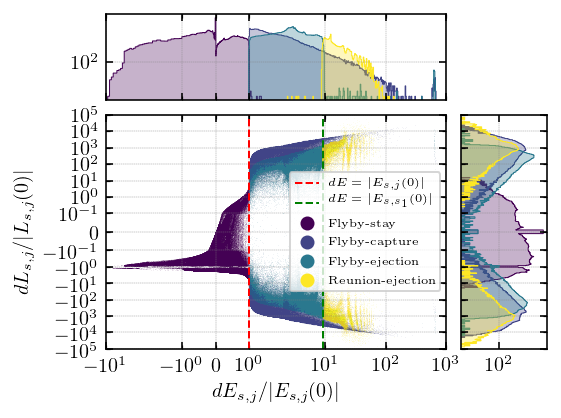

In [59]:

labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-stay', 'Reunion-capture', 'Reunion-ejection']
#labels = ['Reunion-stay', 'Reunion-capture', 'Reunion-ejection']
#labels = ['Collision-$s$-$s_1$', 'Collision-$s$-$J$']
colors = cm.viridis(np.linspace(0, 1, len(labels),endpoint=True))
events = get_detailed__events(single_1,-20,30)

s=0
e=6
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
show_single_planet_EL(ax,'single_planet_EL', single_1, events[s:e], colors[s:e], labels[s:e])

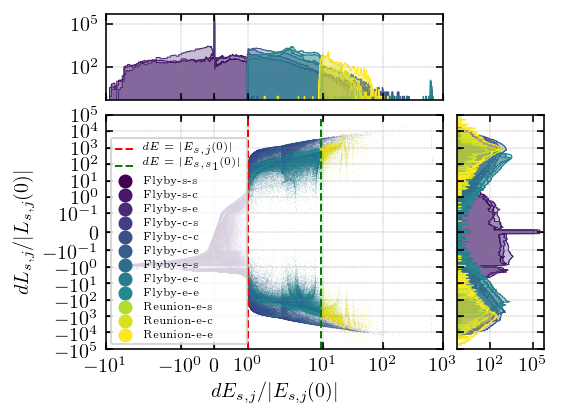

In [35]:
events, labels = get_multi_detailed_events(multi_single,-35,50)

flt = multi_single['b'] < 10000
s=0
e=18
t=1
colors = cm.viridis(np.linspace(0, 1, len(labels[s:e:t]),endpoint=True))

fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(1,1,1)
show_single_planet_EL(ax,'multi_single_planet_EL', multi_single, events[s:e], colors, labels[s:e])

In [20]:
def show_planet_orbit(out):
    a_sj = out['a_{s,j}']
    e_sj = out['e_{s,j}']
    
    
    a_s1j = out['a_{s1,j}']
    e_s1j = out['e_{s1,j}']
    
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_js = out['coll_{s1,j}'] | out['coll_{s,j}']
    coll =  coll_ss | coll_js

    cut = (-20<b)&(b<30) &~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    
    stay_s = out['stay_{s,j}']
    stay_s1 = out['stay_{s1,j}']
    ejection = out['ejection']
    
    vj = out['v_{j}']
    v_mod=np.sqrt((vj**2).sum(axis=1))
    theta = np.arctan2(vj[:,1],vj[:,0])
    
    fig =plt.figure(figsize=(4*2,3*2))
    ax = fig.add_subplot(2,2,1)
    draw_dist_2d(ax,np.log10(a_sj[flyby&stay_s]/AU), e_sj[flyby&stay_s], '$\log_{10}(a_{s,j}/au)$', '$e_{s,j}$', '', 'purple', 100, 0.6)
    ax = fig.add_subplot(2,2,2)
    draw_dist_2d(ax,np.log10(a_s1j[flyby&stay_s1]/AU), e_s1j[flyby&stay_s1], '$\log_{10}(a_{s_1,j}/au)$', '$e_{s_1,j}$', '', 'green', 100, 0.6)
    ax = fig.add_subplot(2,2,3)
    draw_dist_2d(ax, np.log10(v_mod[(flyby)&ejection]/KMS), theta[(flyby)&ejection], '$\log_{10}(v_{\\rm inf}/{\\rm kms})$', '$\\theta$','ejected Jupiter','purple',100,0.6)
    ax = fig.add_subplot(2,2,4)
    draw_dist_2d(ax, np.log10(v_mod[(reunion)&ejection]/KMS), theta[(reunion)&ejection], '$\log_{10}(v_{\\rm inf}/{\\rm kms})$', '$\\theta$','ejected Jupiter','purple',100,0.6)
    
    
    
    #draw_dist_2d(ax, np.log10(v_mod[reunion&ejection]/KMS), theta[reunion&ejection], '$\log_{10}(v_{\\rm inf}/{\\rm kms})$', '$\\theta$','ejected Jupiter','purple',100,0.5)
    
    plt.tight_layout()
    savefig(plt,'single-mono-prop')
    

In [23]:
def show_multi_planet_orbit(out):
    a_sj = out['a_{s,j}']
    e_sj = out['e_{s,j}']
    a_s1j = out['a_{s1,j}']
    e_s1j = out['e_{s1,j}']
    
    
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_js = out['coll_{s1,j}'] | out['coll_{s,j}']
    coll_ns = out['coll_{s1,n}'] | out['coll_{s,n}']
    coll =  coll_ss | coll_js | coll_ns

    cut = (-35<b)&(b<50) &~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    
    stay_sj = out['stay_{s,j}']
    stay_s1j = out['stay_{s1,j}']
    ejection_j = out['ejection_{j}']
    
    stay_sn = out['stay_{s,n}']
    stay_s1n = out['stay_{s1,n}']
    ejection_n = out['ejection_{n}']
    
    vj = out['v_{j}']
    vj_mod=np.sqrt((vj**2).sum(axis=1))
    theta_j = np.arctan2(vj[:,1],vj[:,0])
    
    vn = out['v_{n}']
    vn_mod=np.sqrt((vn**2).sum(axis=1))
    theta_n = np.arctan2(vn[:,1], vn[:,0])
    
    
    fig =plt.figure(figsize=(3*2,3*2))
    
    sz=0.03
    colors=cm.viridis(np.linspace(0,0.8,3,endpoint=True))
    labels=['N-stay','N-captured','N-ejection']
    
    def draw_lab(ax):
        for l,c in zip(labels, colors):
            ax.scatter([],[],color=c,label=l)
        ax.legend()
        
        
    ax = fig.add_subplot(2,2,1)
    draw_scatter_2d(ax, [np.log10(a_sj[flyby&stay_sj&stay_sn]/AU),np.log10(a_sj[flyby&stay_sj&stay_s1n]/AU),np.log10(a_sj[flyby&stay_sj&ejection_n]/AU)],[e_sj[flyby&stay_sj&stay_sn],e_sj[flyby&stay_sj&stay_s1n],e_sj[flyby&stay_sj&ejection_n]], colors, ['.','.','.'], sz,50,50,0.6)
    ax.set_xlabel('$\log_{10}(a_{s,j}/au)$')
    ax.set_ylabel('$e_{s,j}$')
    draw_lab(ax)
    
    ax = fig.add_subplot(2,2,2)
    draw_scatter_2d(ax, [np.log10(a_s1j[flyby&stay_s1j&stay_sn]/AU),np.log10(a_s1j[flyby&stay_s1j&stay_s1n]/AU),np.log10(a_s1j[flyby&stay_s1j&ejection_n]/AU)],[e_s1j[flyby&stay_s1j&stay_sn],e_s1j[flyby&stay_s1j&stay_s1n],e_s1j[flyby&stay_s1j&ejection_n]], colors, ['.','.','.'], sz,50,50,0.6)
    ax.set_xlabel('$\log_{10}(a_{s_1,j}/au)$')
    ax.set_ylabel('$e_{s_1,j}$')
    draw_lab(ax)
    
    ax = fig.add_subplot(2,2,3)
    draw_scatter_2d(ax, [np.log10(vj_mod[flyby&ejection_j&stay_sn]/KMS),np.log10(vj_mod[flyby&ejection_j&stay_s1n]/KMS),np.log10(vj_mod[flyby&ejection_j&ejection_n]/KMS)],[theta_j[flyby&ejection_j&stay_sn],theta_j[flyby&ejection_j&stay_s1n],theta_j[flyby&ejection_j&ejection_n]], colors, ['.','.','.'], sz,50,50,0.6)
    ax.set_xlabel('$\log_{10}(v_{j}/kms)$')
    ax.set_ylabel('$\\theta_{j}$')
    draw_lab(ax)
    
    ax = fig.add_subplot(2,2,4)
    draw_scatter_2d(ax, [np.log10(vj_mod[reunion&ejection_j&stay_sn]/KMS),np.log10(vj_mod[reunion&ejection_j&stay_s1n]/KMS),np.log10(vj_mod[reunion&ejection_j&ejection_n]/KMS)],[theta_j[reunion&ejection_j&stay_sn],theta_j[reunion&ejection_j&stay_s1n],theta_j[reunion&ejection_j&ejection_n]], colors, ['.','.','.'], sz,50,50,0.6)
    ax.set_xlabel('$\log_{10}(v_{j}/kms)$')
    ax.set_ylabel('$\\theta_{j}$')
    draw_lab(ax)
    
    plt.tight_layout()
    savefig(plt,'multi-single-prop','.png','.png')

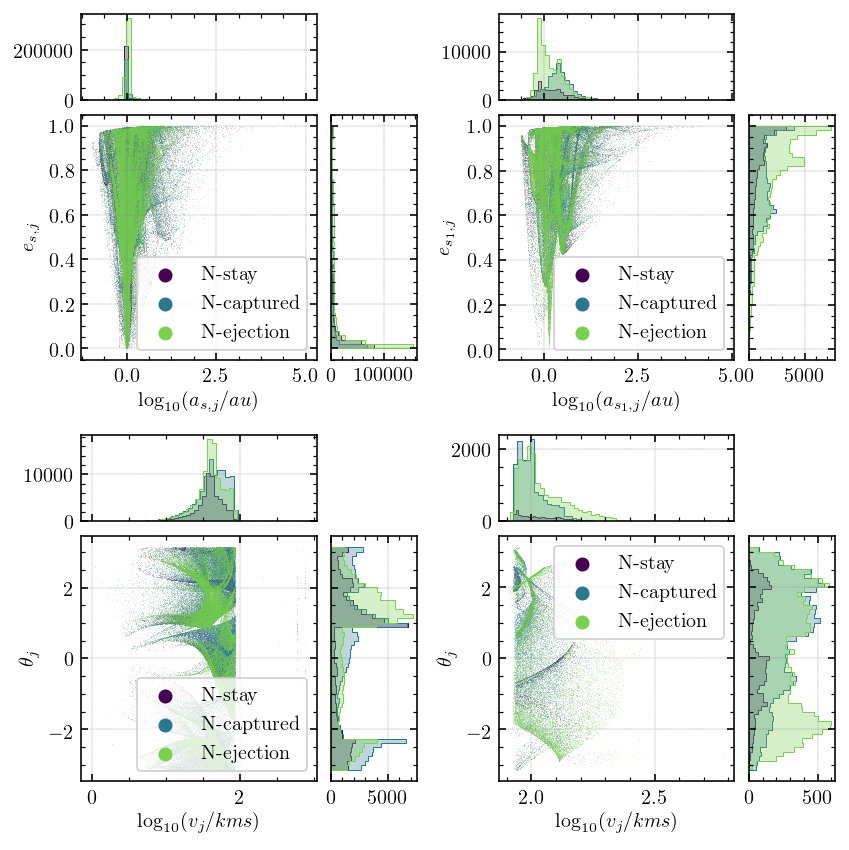

In [24]:
show_multi_planet_orbit(multi_single)

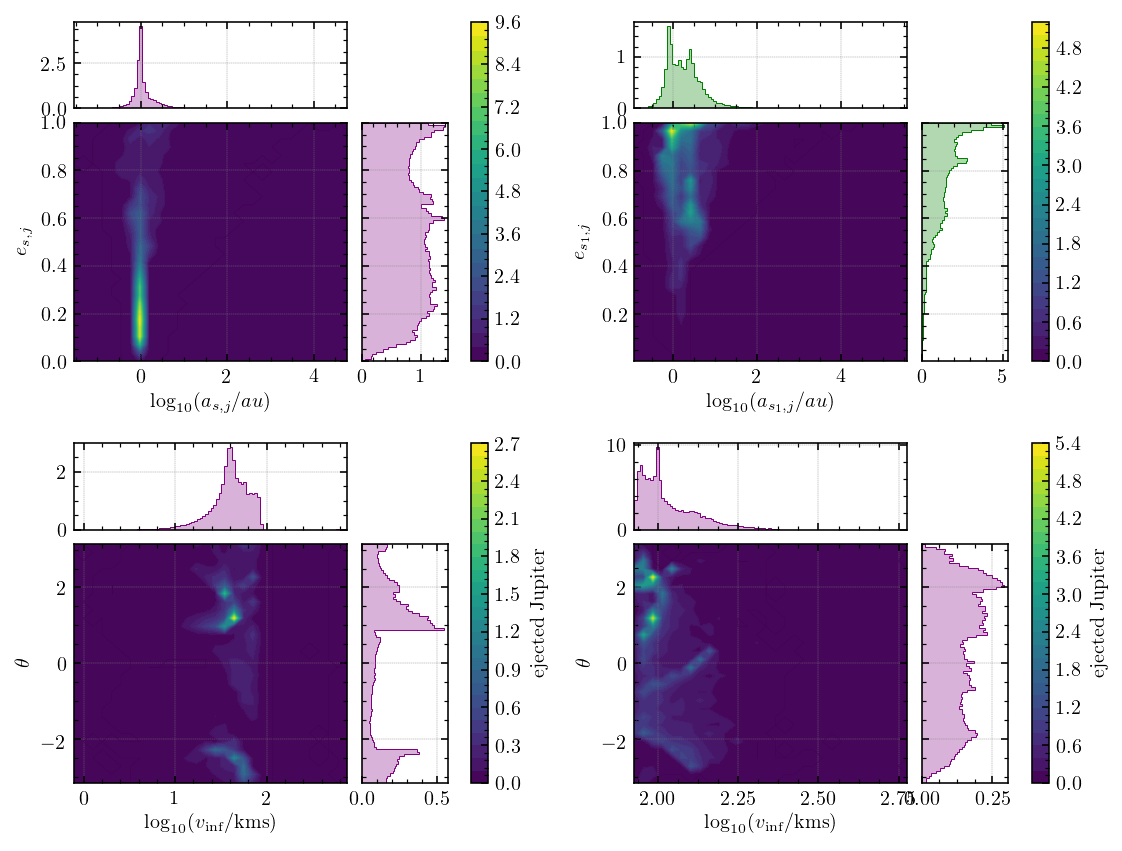

In [21]:
show_planet_orbit(single_1)

In [30]:
(np.sqrt(1*1/2/9.54e-4)*5/np.sqrt(8/np.pi))


71.731640294384079

In [173]:
def calc_t_to_closest(out, angle=0):
    D = 500*AU
    
    b = np.abs(out['b'])
    
    v_inf = out['v_inf']
    
    l = len(v_inf)
    
    v0 = np.zeros((l,3))
    
    v0[:,0] = v_inf
    
    p0 = np.zeros((l,3))
    
    p0[:,0] = D
    
    p0[:,1] = b
    
    u = G*(out['m_{j}'] + out['m_{s}'] + out['m_{s1}'])
    
    a, e = get_a_e(u, p0,v0)
    
    r = np.sqrt(b**2 + D**2)
    
    cos_theta = (a* (1 - e**2) - r )/(e*r)
    
    cosh_E = (e + cos_theta)/(1 + e * cos_theta)
    
    E = np.arccosh(cosh_E)
    
    M = e * np.sinh(E) - E
    
    t = np.sqrt( -a**3/u)*M
    
    cos_angle = np.cos(angle)
    
    cosh_p = (e + cos_angle)/(1 + e * cos_angle)
    
    E_p = np.arccosh(cosh_p)
    
    M_p = e * np.sinh(E_p) - E_p
    
    t_p = np.sqrt( -a**3/u)*M_p
    
    return t - t_p, a, e 

def min_of_max_theta(out, b_max):
    
    t, a, e = calc_t_to_closest(out)
    theta_max = np.arccos(-1/e)
    
    b = -a*np.sqrt(e**2-1)
    
    return theta_max[b<b_max].min()
    
def show_single_star_phase(ax, name, pname, out, events, colors, labels, fltr, angle = 0):
    b = out['b']
    nv = out['s'+pname+'-orbit-nv']+out['s'+pname+'-orbit-omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    aj = 1*AU
    
    omega_j = np.sqrt(G*(out['m_{j}'] + out['m_{s}'])/aj**3)
    
    t_c, a, e = calc_t_to_closest(out,angle)
    
    
    nv = nv + omega_j*t_c 
    
    N = np.floor(nv/np.pi/2)
    
    nv = nv - N*np.pi*2
    
    real_b = -a*np.sqrt(e**2-1)
    real_b[b<0] = -real_b[b<0]

    
    flt =10
    #for event, color, label in zip(events, colors, labels):
    #    if(event.sum() > flt):
    #        ax.scatter([],[],color=color,label=label)
   
    sz=.1
    bmax = 0
    bmin = 0
    for event, color in zip(events, colors):
        if (event&fltr).sum() > 0:
            bmax = max(bmax, real_b[event&fltr].max())
            bmin = min(bmin, real_b[event&fltr].min())
        ax.scatter(real_b[event&fltr], nv[event&fltr], color=color, lw=0, s=sz)
    
    ax.set_xlabel('b [au]')
    ax.set_ylabel('$\eta_'+pname+'$')
    ax.set_ylim(0,2*np.pi)
    
    ax.set_xlim(bmin,bmax)
    #ax.set_xscale('symlog')
    
    plt.tight_layout()
    plt.legend(loc='lower right',fontsize=6,framealpha=0.6)
    savefig(plt,name,'.png','.png')

In [117]:
def get_first_class_events(out,  pname, low, high):
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_ps = (out['coll_{s1,'+pname+'}'] | out['coll_{s,'+pname+'}'] )& (low<b)&(b<high)
    coll =  (coll_ss | coll_ps)  
    
    cut = (low<b)&(b<high)& ~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    res = [flyby, coll, reunion]
    
    if 'disrupted' in out:
        res.append(out['disrupted'] & cut)
    return res

def get_detailed__events(out, pname,low, high):
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_ps = (out['coll_{s1,'+pname+'}'] | out['coll_{s,'+pname+'}'] )&(low<b)&(b<high) 
    coll_os =  (out['coll_{s1,j}'] | out['coll_{s,j}']) & (low<b)&(b<high)
    coll =  (coll_ss | coll_os)  

    cut = (low<b)&(b<high) & ~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    
    stay_s = out['stay_{s,'+pname+'}']
    stay_s1 = out['stay_{s1,'+pname+'}']
    ejection = out['ejection_{'+pname+'}']
    
    return flyby&stay_s, flyby&stay_s1, flyby&ejection, reunion&stay_s, reunion&stay_s1, reunion&ejection, coll_ss, coll_ps

def get_multi_first_class_events(out, low, high):
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_ps = (out['coll_{s1,j}'] | out['coll_{s,j}'] | out['coll_{s1,n}'] | out['coll_{s,n}'] )
    coll =  (coll_ss | coll_ps)  & (low<b)&(b<high)
    
    cut = (low<b)&(b<high)& ~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    res = [flyby, coll, reunion]
    return res

def get_multi_detailed_events(out,low, high):
    b = out['b']
    coll_ss = out['coll_{s,s1}']
    coll_js = (out['coll_{s1,j}'] | out['coll_{s,j}'] ) &(low<b)&(b<high) 
    coll_ns = (out['coll_{s1,n}'] | out['coll_{s,n}'] ) &(low<b)&(b<high) 
    
    coll =  (coll_ss | coll_js | coll_ns)  

    cut = (low<b)&(b<high) & ~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    
    stay_sj = out['stay_{s,j}']
    stay_s1j = out['stay_{s1,j}']
    ejection_j = out['ejection_{j}']
    
    stay_sn = out['stay_{s,n}']
    stay_s1n = out['stay_{s1,n}']
    ejection_n = out['ejection_{n}']
    
    sfate = [flyby, reunion]
     
    jfate = [stay_sj, stay_s1j, ejection_j]
    
    nfate = [stay_sn, stay_s1n, ejection_n]
    
    res=[]
    for s in sfate:
        for j in jfate:
            for n in nfate:
                res.append(s&j&n)
    res.append(coll_ss)
    res.append(coll_js)
    res.append(coll_ns)
    
    slabel = ['Flyby-', 'Reunion-']
    jlabel = ['s-','c-','e-']
    nlabel = ['s','c','e']

    labels=[]
    for s in slabel:
        for j in jlabel:
            for n in nlabel:
                labels.append(s+j+n)
    labels.append('Collision-$s$-$s_1$')
    labels.append('Collision-$s$-$j$')
    labels.append('Collision-$s$-$n$')
    
    return res,labels


In [174]:
import matplotlib.pyplot as plt
import subprocess
from numba import jit
def create_movie(name,out, events, colors, labels, flt, update):
    #x_min, x_max, y_min, y_max = -200,100,-15,15#boarder(out)
    
    
    f = plt.figure(frameon=True, figsize=(3,2.25), dpi=600)
    canvas_width, canvas_height = f.canvas.get_width_height()
    #ax = f.add_axes([0, 0, 1, 1])
    ax =f.add_subplot(1,1,1)
    
    ax.set_xlim([-30,30])
    ax.set_ylim([0,2*np.pi])
# Open an ffmpeg process
    outf = name
    cmdstring = ('ffmpeg', 
        '-y', '-r', '30', # overwrite, 30fps
        '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
        '-pix_fmt', 'argb', # format
        '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
        '-vcodec', 'mpeg4', outf) # output encoding
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

# Draw 1000 frames and write to the pipe
    max_theta = min_of_max_theta(out,30)
    
    
    
    for theta in np.linspace(max_theta,0,180,endpoint=True):
        # draw the frame
        update(ax, '', 'j', out, events, colors, labels,flt, theta)
        
        
        plt.draw()

    # extract the image as an ARGB string
        string = f.canvas.tostring_argb()

    # write to pipe
        p.stdin.write(string)

# Finish up
    p.communicate()

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccosh
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in lege

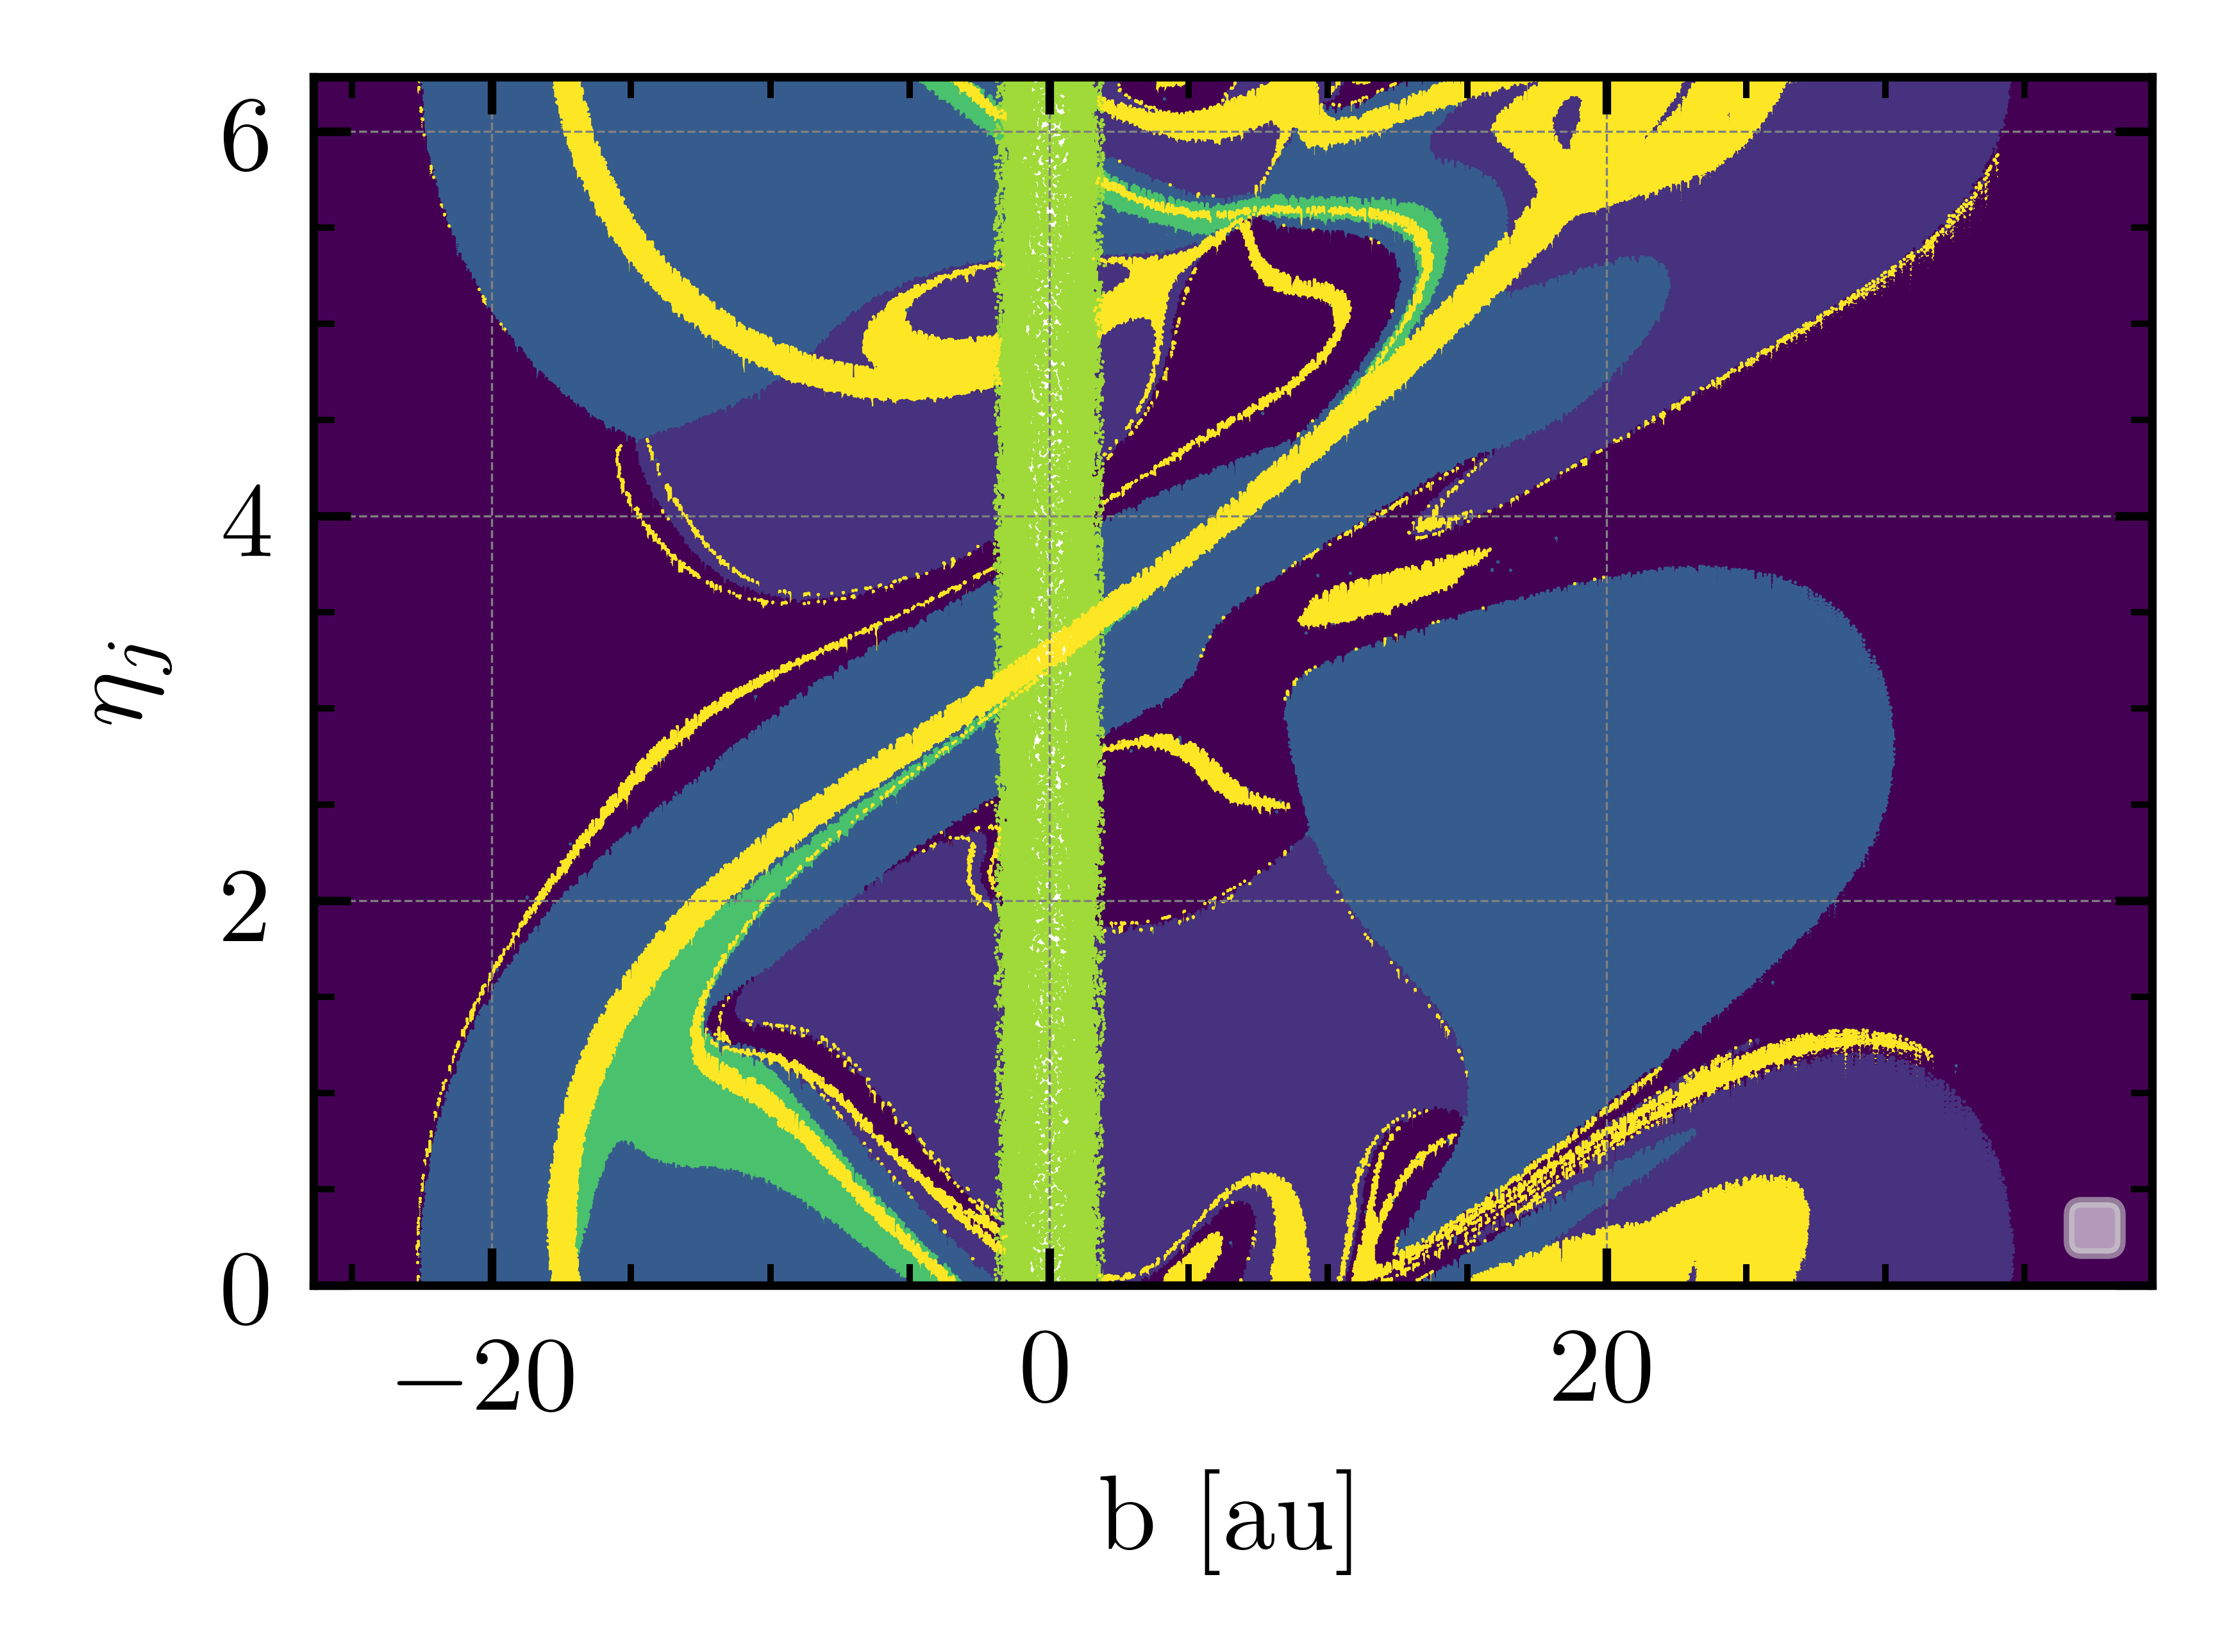

In [175]:
labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-stay', 'Reunion-capture', 'Reunion-ejection', 'Collision-$s$-$s_1$', 'Collision-$s$-$J$']
colors = cm.viridis(np.linspace(0, 1, len(labels),endpoint=True))
events = get_detailed__events(single_1,'j',-20,30)
flt = single_1['b'] < 10000
s=0
e=8
create_movie('single_planet_movie.mp4',single_1,events[s:e], colors[s:e], labels[s:e],flt,show_single_star_phase)



In [10]:
def get_binary_sub(out,angle):
    I = out['ss-orbit-i']
    return np.abs(I-angle) < 1e-3

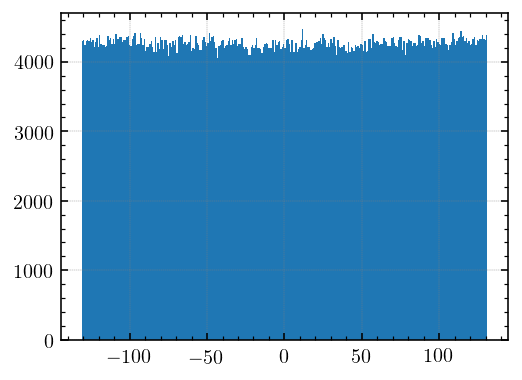

In [153]:
labels = ['Flyby', 'Collision', 'Reunion']
colors = cm.viridis(np.linspace(0,1,len(labels),endpoint=True))
events = get_first_class_events(single_1,'j',-20,30)
flt = single_1['b'] < 10000
show_single_star_phase('single_star_phase', 'j',single_1, events, colors, labels,flt)

1440789
235896
24738


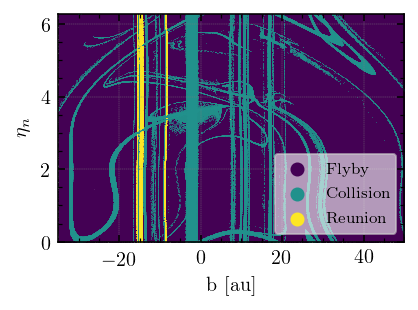

In [91]:
labels = ['Flyby', 'Collision', 'Reunion']
colors = cm.viridis(np.linspace(0,1,len(labels),endpoint=True))
nv_p = 'n'
events = get_multi_first_class_events(multi_single,-35,50)
flt = multi_single['b'] < 10000

show_single_star_phase('multi_single_star_'+nv_p+'_phase', nv_p, multi_single, events, colors, labels,flt)

115516
150351
200090
49272


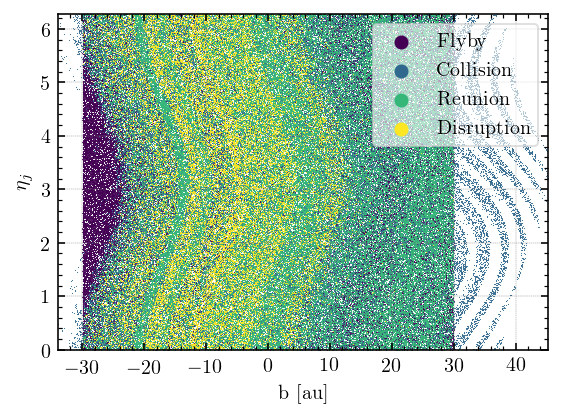

In [77]:
labels = ['Flyby', 'Collision', 'Reunion' ,'Disruption']
colors = cm.viridis(np.linspace(0,1,len(labels),endpoint=True))
events = get_first_class_events(binary_1,-30,30)
ori = get_binary_sub(binary_1, 0)
show_single_star_phase('pro_binary1_star_phase', binary_1, events, colors, labels, ori)

62533
203834
1216378
40035


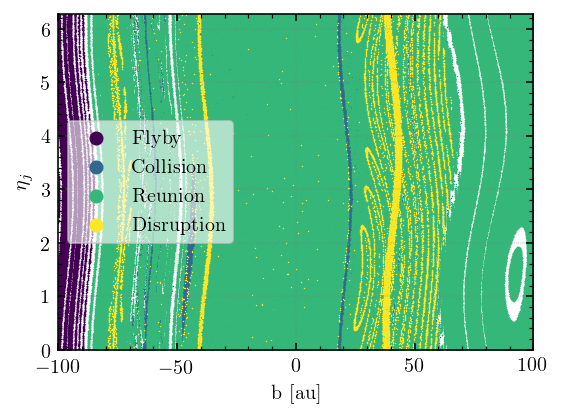

In [60]:
events = get_first_class_events(binary_50,-100,100)
ori = get_binary_sub(binary_50, 0)
show_single_star_phase('pro_binary50_star_phase', binary_50, events, colors, labels, ori)

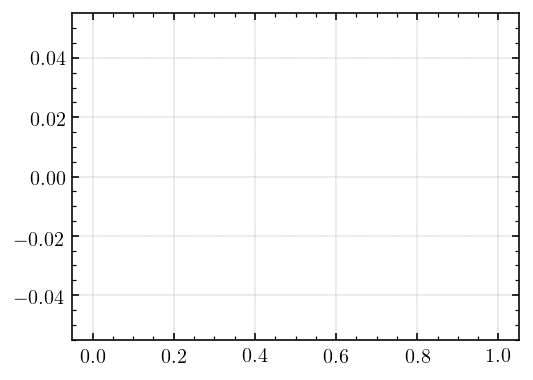

In [137]:
labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-stay', 'Reunion-capture', 'Reunion-ejection', 'Collision-$s$-$s_1$', 'Collision-$s$-$J$']
#labels = ['Reunion-stay', 'Reunion-capture', 'Reunion-ejection']
#labels = ['Collision-$s$-$s_1$', 'Collision-$s$-$J$']
colors = cm.viridis(np.linspace(0, 1, len(labels),endpoint=True))
events = get_detailed__events(single_1,'j',-20,30)
flt = single_1['b'] < 10000
s=0
e=8
show_single_star_phase('single_planet_p', 'j',single_1, events[s:e], colors[s:e], labels[s:e],flt,140.0/180*np.pi)

169395
186356
592630
61070
83056
124561
68164
72058
75981
0
1
0
0
0
0
1246
15667
7655
53981
79037
102878


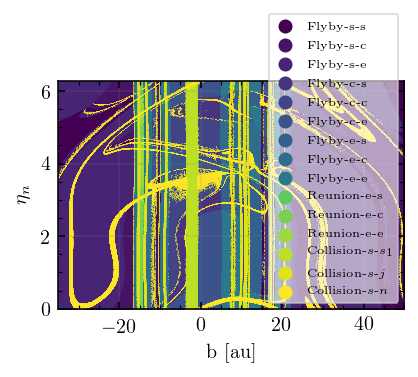

In [97]:
events, labels = get_multi_detailed_events(multi_single,-35,50)

flt = multi_single['b'] < 10000
s=0
e=21
t=1
colors = cm.viridis(np.linspace(0, 1, len(labels[s:e:t]),endpoint=True))

nv_name ='n'
show_single_star_phase('multi_single_planet_'+nv_name+'', nv_name, multi_single, events[s:e:t], colors, labels[s:e:t],flt)

In [ ]:
labels = ['Flyby', 'Collision', 'Reunion']
colors = cm.viridis(np.linspace(0,1,3))
events = get_first_class_events(single_1)
show_single_star_phase('single_star_phase', single_1, events, colors, labels)

In [ ]:
def show_single_star_phase(out):
    b = out['b']
    nv = out['sj-orbit-nv']+out['sj-orbit-omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    coll_ss = out['coll_{s,s1}']
    coll_js = out['coll_{s1,j}'] | out['coll_{s,j}']
    coll =  coll_ss | coll_js

    cut = (-20<b)&(b<30) & ~coll
    
    reunion=out['reunion'] & cut
    
    flyby = out['flyby'] & cut
    
    fig = plt.figure(figsize=(4,3))
    ax=fig.add_subplot(1,1,1)
    
    labels = ['Flyby', 'Collision', 'Reunion']
    
    colors = cm.viridis(np.linspace(0,1,3))
    for color, label in zip(colors, labels):
        ax.scatter([],[],color=color,label=label)
   
    sz=.1
    
    ax.scatter(b[flyby], nv[flyby],color=colors[0],lw=0,s=sz)
    ax.scatter(b[coll], nv[coll],color=colors[1],lw=0,s=sz)
    ax.scatter(b[reunion], nv[reunion],color=colors[2],lw=0,s=sz)
    
    ax.set_xlabel('b [au]')
    ax.set_ylabel('$\eta_j$')
    ax.set_ylim(0,2*np.pi)
    ax.set_xlim(-20,30)
    
    plt.tight_layout()
    plt.legend(fontsize=6)
    savefig(plt,'single_star_phase','.png','.png')

In [74]:
def show_single_star_phase_at_closest(data):
    b = data['b']
    
    ms = data['m_{s}']
    ps = data['closest:p_{s}']
    vs = data['closest:v_{s}']
    
    mj = data['m_{j}']
    pj = data['closest:p_{j}']
    vj = data['closest:v_{j}']
    
    ms1 = data['m_{s1}']
    ps1 = data['closest:p_{s1}']
    vs1 = data['closest:v_{s1}']
    
    cmp = (ms[0]*ps + mj[0]*pj)/(ms[0]+mj[0])
    cmv = (ms[0]*vs + mj[0]*vj)/(ms[0]+mj[0])
    
    rp = ps1 - cmp
    rv = vs1 - cmv
    
    an = angle_between_2d_vec(rp, rv)
    
    
    
    rp_mod = np.sqrt((rp**2).sum(axis=1))
    rp_mod[an<0] = -rp_mod[an<0]
    
    psj = pj -ps
    
    #select = np.abs(b) < 30 
    
    theta = angle_between_2d_vec(rp, psj) 
    
    select = np.abs(rp_mod) < 5
    
    states = get_detailed__events(data,'j',-100,100)#get_first_class_events(data,'j',-20,30)
    
    #states = [flyby&stay_sj, flyby&stay_s1j, flyby&ejection_j, reunion&ejection_j]
    colors = cm.viridis(np.linspace(0,1,len(states)))
    
    
    #plt.scatter(rp_mod[states[-1]], theta[states[-1]],lw=0,s=1)
    #plt.scatter(b[states[1]],rp_mod[states[1]],s=0.1,lw=0)
    
    #for s in states:
        
     #   plt.scatter(rp_mod[s], theta[s],lw=0,s=1)
    #return
    plt.figure(figsize(4,3))
    for s, c in zip(states[0:-2], colors):
        #plt.scatter(pj[flyby,0],pj[flyby,1])
        #plt.hist(yy[s],20,alpha=0.5,color=c,density=True)
        plt.scatter(rp_mod[s&select], theta[s&select],s=.1,color=c,lw=0)
    
    
    savefig(plt,'mono-single-old','.png','.png')

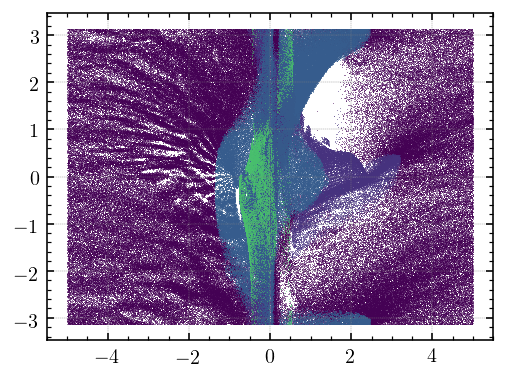

In [75]:
show_single_star_phase_at_closest(single_1)

In [12]:
def mod(x):
    return np.sqrt((x**2).sum(axis=1))

def angle_between_2d_vec(x, y):
    dot = x[:,0]*y[:,0] + x[:,1]*y[:,1]      # dot product
    det = x[:,0]*y[:,1] - x[:,1]*y[:,0]      # determinant
    return np.arctan2(det, dot)  
    #return np.arccos((x*y).sum(axis=1)/mod(x)/mod(y))

def mono_single_closest(data):
    b = data['b']
    
    ms = data['m_{s}']
    ps = data['closest:p_{s}']
    vs = data['closest:v_{s}']
    
    mj = data['m_{j}']
    pj = data['closest:p_{j}']
    vj = data['closest:v_{j}']
    
    ms1 = data['m_{s1}']
    ps1 = data['closest:p_{s1}']
    vs1 = data['closest:v_{s1}']
    
    cmp = (ms[0]*ps + mj[0]*pj)/(ms[0]+mj[0])
    
    cmv = (ms[0]*vs + mj[0]*vj)/(ms[0]+mj[0])
    
    rp = ps1 - cmp
    rv = vs1 - cmv
    
    rp_mod = mod(rp)
    rp_mod[b<0] = -rp_mod[b<0]
    
    rv_mod = mod(rv)
    
    psj = (pj - ps)
    vsj = (vj - vs)

    select = np.abs(b) < 30 
    
    theta = angle_between_2d_vec(rp, psj) 
    
    #yy = np.cos(theta) * rv_mod
    
    coll_ss = data['coll_{s,s1}']
    coll_js = data['coll_{s1,j}'] | data['coll_{s,j}']
    coll =  coll_ss | coll_js
    cut = ~coll &( np.abs(b) < 30) & (np.abs(rp_mod) > 0 )
    
    reunion=data['reunion'] & cut
    flyby = data['flyby'] & cut
    
    stay_sj = data['stay_{s,j}']
    stay_s1j = data['stay_{s1,j}']
    ejection_j = data['ejection_{j}']
    
    states = [flyby&stay_sj, flyby&stay_s1j, flyby&ejection_j, reunion&ejection_j]
    colors = cm.viridis(np.linspace(0,1,len(states)))
    
    for s, c in zip(states, colors):
        #plt.hist(yy[s],20,alpha=0.5,color=c,density=True)
        plt.scatter(rp_mod[s], theta[s],s=0.1,color=c,lw=0)
    
    
    savefig(plt,'mono-single','.png','.png')
    

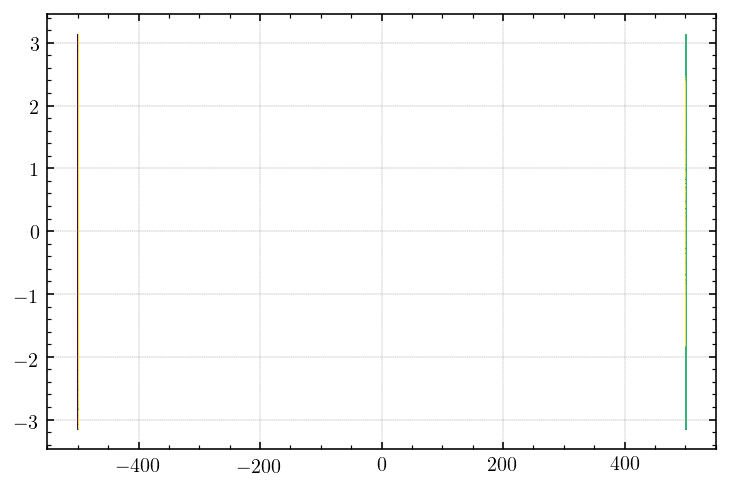

In [13]:
mono_single_closest(single_1)

In [635]:

def Grav(m1, m2, p1, p2):
    dr = p1 - p2
    r = mod(dr)
    return G*m1*m2*dr/ np.array([r**3,]*3).transpose()

def show_impulse(data):
    b = data['b']
    
    ms = data['m_{s}'][0]
    ps = data['closest:p_{s}']
    vs = data['closest:v_{s}']
    
    mj = data['m_{j}'][0]
    pj = data['closest:p_{j}']
    vj = data['closest:v_{j}']
    
    ms1 = data['m_{s1}'][0]
    ps1 = data['closest:p_{s1}']
    vs1 = data['closest:v_{s1}']
    
    F_sj = Grav(ms, mj, ps, pj)
    
    F_s1j = Grav(ms1, mj, ps1, pj)
    
    F_tot = F_s1j + F_sj
    
    F = mod(F_tot)
    
    cmv = (ms*vs + mj*vj )/(ms+mj)
    
    T = 1/mod((vs1-cmv))
    
    
    I = F * T
    
    rp = ps - pj

    select = np.abs(b) < 100 
    
    theta = angle_between_2d_vec(rp, F_tot) 
    
    #yy = np.cos(theta) * rv_mod
    
    coll_ss = data['coll_{s,s1}']
    coll_js = data['coll_{s1,j}'] | data['coll_{s,j}']
    coll =  coll_ss | coll_js
    cut = ~coll &( np.abs(b) <100) 
    
    reunion=data['reunion'] & cut
    flyby = data['flyby'] & cut
    
    stay_sj = data['stay_{s,j}']
    stay_s1j = data['stay_{s1,j}']
    ejection_j = data['ejection_{j}']
    
    states = [flyby&stay_sj, flyby&stay_s1j, flyby&ejection_j, reunion&ejection_j]
    labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-ejection']
    colors = cm.viridis(np.linspace(0,1,len(states)))
    
    for c, l in zip(colors, labels):
        plt.scatter([],[],color=c, label=l)
    plt.legend()
    
    for s, c in zip(states, colors):
        #plt.hist(yy[s],20,alpha=0.5,color=c,density=True)
        plt.scatter(theta[s], np.log10(I[s]),s=0.3,color=c,lw=0)
    #plt.yscale('symlog')
    plt.ylim([-4,0])
    plt.xlabel('$\\theta$')
    plt.ylabel('$\log_{10}(I_{\\rm tot})$')
    savefig(plt,'mono-single-I','.png','.png')
    

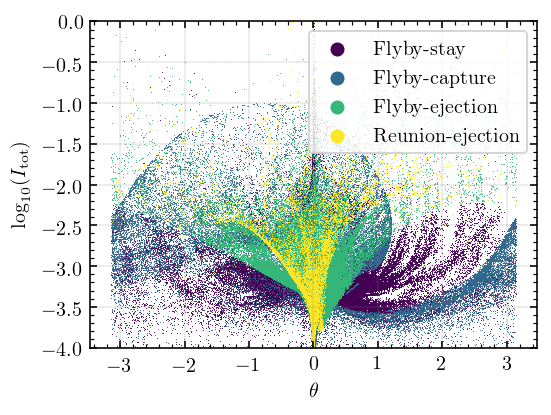

In [636]:
show_impulse(single_1)

In [648]:
def show_binary_impulse(data):
    b = data['b']
    
    ms = data['m_{s}'][0]
    ps = data['closest:p_{s}']
    vs = data['closest:v_{s}']
    
    mj = data['m_{j}'][0]
    pj = data['closest:p_{j}']
    vj = data['closest:v_{j}']
    
    ms1 = data['m_{s1}'][0]
    ps1 = data['closest:p_{s1}']
    vs1 = data['closest:v_{s1}']
    
    ms2 = data['m_{s2}'][0]
    ps2 = data['closest:p_{s2}']
    vs2 = data['closest:v_{s2}']
    
    F_sj = Grav(ms, mj, ps, pj)
    
    F_s1j = Grav(ms1, mj, ps1, pj)
    
    F_s2j = Grav(ms2, mj, ps2, pj)
    
    F_tot = F_s1j + F_sj + F_s2j
    
    F = mod(F_tot)
    
    cmv = (ms*vs + mj*vj )/(ms+mj)
    
    cmvbi = (ms1*vs1 + ms2*vs2 )/(ms1+ms2)
    
    T = 1/mod((cmvbi-cmv))
    
    
    I = F * T
    
    rp = ps - pj

    select = np.abs(b) < 100 
    
    theta = angle_between_2d_vec(rp, F_tot) 
    
    #yy = np.cos(theta) * rv_mod
    
    coll_ss = data['coll_{s,s1}']
    coll_js = data['coll_{s1,j}'] | data['coll_{s,j}'] | data['coll_{s2,j}'] 
    coll =  coll_ss | coll_js
    cut = ~coll &( np.abs(b) <100) 
    
    reunion=data['reunion'] & cut
    flyby = data['flyby'] & cut
    
    stay_sj = data['stay_{s,j}']
    stay_sbj = data['stay_{s1,j}'] | data['stay_{s2,j}']
    ejection_j = data['ejection_{j}']
    
    states = [flyby&stay_sj, flyby&stay_sbj, flyby&ejection_j, reunion&ejection_j]
    labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-ejection']
    colors = cm.viridis(np.linspace(0,1,len(states)))
    
    for c, l in zip(colors, labels):
        plt.scatter([],[],color=c, label=l)
    plt.legend()
    
    for s, c in zip(states, colors):
        #plt.hist(yy[s],20,alpha=0.5,color=c,density=True)
        plt.scatter(theta[s], np.log10(I[s]),s=0.3,color=c,lw=0)
    #plt.yscale('symlog')
    plt.ylim([-6,0])
    plt.xlabel('$\\theta$')
    plt.ylabel('$\log_{10}(I_{\\rm tot})$')
    savefig(plt,'mono-binary-I','.png','.png')
    

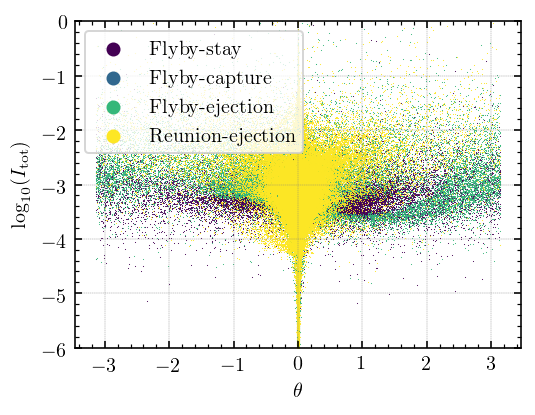

In [649]:
show_binary_impulse(binary_1)

In [660]:
def show_multi_impulse(data):
    b = data['b']
    
    ms = data['m_{s}'][0]
    ps = data['closest:p_{s}']
    vs = data['closest:v_{s}']
    
    mj = data['m_{j}'][0]
    pj = data['closest:p_{j}']
    vj = data['closest:v_{j}']
    
    
    mn = data['m_{n}'][0]
    pn = data['closest:p_{n}']
    vn = data['closest:v_{n}']
    
    ms1 = data['m_{s1}'][0]
    ps1 = data['closest:p_{s1}']
    vs1 = data['closest:v_{s1}']
    
    
    
    F_sj = Grav(ms, mj, ps, pj)
    
    F_nj = Grav(ms, mn, pn, pj)
    
    F_s1j = Grav(ms1, mj, ps1, pj)
    
    F_tot = F_s1j + F_sj + F_nj
    
    F = mod(F_tot)
    
    cmv = (ms*vs + mj*vj + mn*vn)/(ms+mj+ mn)
    
    
    
    T = 1/mod((vs1-cmv))
    
    
    I = F * T
    
    rp = ps - pj

    select = np.abs(b) < 100 
    
    theta = angle_between_2d_vec(rp, F_tot) 
    
    #yy = np.cos(theta) * rv_mod
    
    coll_ss = data['coll_{s,s1}']
    coll_js = data['coll_{s1,j}'] | data['coll_{s,j}'] | data['coll_{s1,n}'] | data['coll_{s,n}'] 
    
    coll =  coll_ss | coll_js
    cut = ~coll &( np.abs(b) <100) 
    
    reunion=data['reunion'] & cut
    flyby = data['flyby'] & cut
    
    stay_sj = data['stay_{s,j}']
    stay_sbj = data['stay_{s1,j}'] 
    ejection_j = data['ejection_{j}']
    
    states = [flyby&stay_sj, flyby&stay_sbj, flyby&ejection_j, reunion&ejection_j]
    labels = ['Flyby-stay', 'Flyby-capture', 'Flyby-ejection', 'Reunion-ejection']
    colors = cm.viridis(np.linspace(0,1,len(states)))
    
    for c, l in zip(colors, labels):
        plt.scatter([],[],color=c, label=l)
    plt.legend()
    
    for s, c in zip(states, colors):
        #plt.hist(yy[s],20,alpha=0.5,color=c,density=True)
        plt.scatter(theta[s], np.log10(I[s]),s=0.3,color=c,lw=0)
    #plt.yscale('symlog')
    plt.ylim([-4,0])
    plt.xlabel('$\\theta$')
    plt.ylabel('$\log_{10}(I_{\\rm tot})$')
    savefig(plt,'multi-single-I','.png','.png')
    

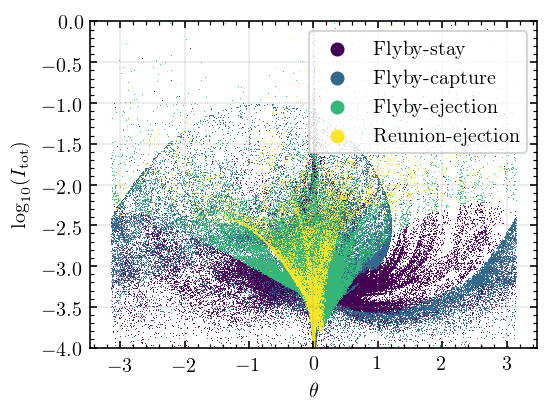

In [661]:
show_multi_impulse(multi_single)

In [374]:

mj=9.55e-4
mn=5.15e-5
aj=1
an=5
rs=0.00465
AJ =aj*mj/(1+mj)
AN= an*mn/(1+mn)

print(AJ/rs, AN/rs)

0.20518039680707076 0.05537349235116541


In [375]:
def show_single_phase_map(out):
    b = out['b']
    nv = out['sj-orbit-nv']+out['sj-orbit-omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    coll_ss = out['coll_{s,s1}']
    coll_js = out['coll_{s1,j}'] | out['coll_{s,j}']
    coll =  coll_ss | coll_js

    cut = (-20<b)&(b<30) & ~coll
    ej = out['ejection'] & cut
    bd = out['stay_{s,j}'] & cut
    hj = out['HJ_{s,j}'] & cut
    cp = out['stay_{s1,j}'] & cut
    HJ_s1 = out['HJ_{s1,j}'] & cut
    
    reunion=out['reunion'] & cut
    
    weak = ~(coll | ej | bd | cp | reunion )
    
    
    fig = plt.figure(figsize=(4,3))
    ax=fig.add_subplot(1,1,1)
    #ax.hist(nv)
    #ax.scatter(b[reunion],nv[reunion],color='r',lw=0,s=0.3)
    labels = ['Jupiter ejection','captured cool Jupiter', 'cool Jupiter', 'hot Jupiter','captured hot Jupiter']
    
    colors = cm.viridis(np.linspace(0,1,5))
    for color, label in zip(colors, labels):
        ax.scatter([],[],color=color,label=label)
    #ax.scatter([],[],color='k',label='star-star collision')
    #ax.scatter([],[],color='r',label='star-Jupiter collision')
    
    #ax.contourf(x, y, z)
    sz=.1
    
    ax.scatter(b[reunion],nv[reunion],color='orange',lw=0,s=sz)
    ax.scatter(b[bd],nv[bd],color=colors[2],lw=0,s=sz)
    ax.scatter(b[cp],nv[cp],color=colors[1],lw=0,s=sz)
    ax.scatter(b[ej],nv[ej],color=colors[0],lw=0,s=sz)
    #ax.scatter(b[coll_ss],nv[coll_ss],color='k',lw=0,s=sz)
    #ax.scatter(b[coll_js],nv[coll_js],color='r',lw=0,s=sz)
    
    
    
    ax.scatter(b[hj],nv[hj],color=colors[3],lw=0,s=20*sz)
    ax.scatter(b[HJ_s1],nv[HJ_s1],color=colors[4],lw=0,s=20*sz)
    ax.scatter(b[weak],nv[weak],color='b',lw=0,s=sz)
    
    ax.set_xlabel('b [au]')
    ax.set_ylabel('$\eta_j$')
    ax.set_ylim(0,2*np.pi)
    ax.set_xlim(-20,30)
    
    plt.tight_layout()
    plt.legend(fontsize=6)
    savefig(plt,'single_phase_map','.png','.png')

In [13]:
show_single_phase_map(single_1)

KeyError: 'ejection'

In [ ]:
def tidal_scale_e(outcomes,skey, loga):
    rp = outcomes['rj'][0]
    ms = outcomes['m'+skey][0]
    mp = outcomes['mj'][0]
    a = 10**loga
    
    p = 9.0/4/2.5e4*ms/mp*rp**5    
    n = np.sqrt( G*(ms+mp)/a**3)
    
    e =np.sqrt(3/n*a**5/14/p/Hubble_t)
    e[e>=1] = 1
    return e
    
def draw_single_scatter_prop(out):
    coll =  out['scattering'][0]['coll_js1'] | out['scattering'][0]['coll_ss1'] | out['scattering'][0]['coll_js']
    cut =  ~coll
    ej = out['scattering'][0]['e-'] & cut
    bd = out['scattering'][0]['b-'] & cut
    hj = out['scattering'][0]['HJ'] & cut
    cp = out['scattering'][0]['capture_js1'] & cut
    HJ_s1 = out['scattering'][0]['HJ_s1'] & cut
    reunion = out['scattering'][0]['reunion_s1'] & cut
    
    
    b = out['scattering'][0]['b'] 
    a_ss1 = out['scattering'][0]['e_ss1'] 
    
    plt.hist(b[reunion],30)
    #plt.yscale('log')
    return
    a_js = out['scattering'][0]['a_js']
    e_js = out['scattering'][0]['e_js']
    
    a_js1 = out['scattering'][0]['a_js1']
    e_js1 = out['scattering'][0]['e_js1']
    
    v = out['scattering'][0]['vj']
    v_mod=np.sqrt((v**2).sum(axis=1))
    theta = np.arctan2(v[:,1],v[:,0])
    
    def cri_e(loga,p=0.1*AU):
        a=10**loga
        return np.sqrt(1-p/a)
    
    fig = plt.figure(figsize=(7.5,6))
    ax = fig.add_subplot(2,2,3)
    draw_dist_2d(ax, np.log10(a_js[bd]/AU), (e_js[bd]), '$\log_{10}(a_j/{\\rm au})$', '$e_j$','stayed Jupiter','purple',10,0.6)
    aaj = np.linspace(max(np.log10(a_js[bd]).min(), -1), np.log10(a_js[bd]).max(),100)
    eej = cri_e(aaj)
    tidal_e = tidal_scale_e(out['scattering'][0],'s',aaj)
    
    ax.fill_between((aaj/AU), tidal_e,1, color='red',label='HJ candidate',alpha=0.4)
    ax.set_ylim(0,1)
    ax.legend(fontsize=10,loc=4)
    
    
    ax = fig.add_subplot(2,2,4)
    draw_dist_2d(ax, np.log10(a_js1[cp]/AU), (e_js1[cp]), '$\log_{10}(a_j/{\\rm au})$', '$e_j$','captured Jupiter','purple',10,0.6)
    aaj = np.linspace(max(np.log10(a_js1[cp]).min(), -1), np.log10(a_js1[cp]).max(),100)
    eej = cri_e(aaj)
    tidal_e = tidal_scale_e(out['scattering'][0],'s1',aaj)

    ax.fill_between((aaj/AU), tidal_e, 1, color='red',label='HJ candidate',alpha=0.4)
    ax.set_ylim(0,1)
    ax.legend(fontsize=10,loc=4)
    
    ax = fig.add_subplot(2,2,2)
    draw_dist_2d(ax, np.log10(v_mod[ej]/KMS), theta[ej], '$\log_{10}(v_{\\rm inf}/{\\rm kms})$', '$\\theta$','ejected Jupiter','purple',10,0.6)
    
    
    b = np.abs(out['scattering'][0]['b'])
    
    ax = fig.add_subplot(2,2,1)
    labels = ['ejected', 'captured', 'stayed', 'collision', 'weak']
    tot_sim_num = len(ej)/100
    
    uni = [ej.sum()/tot_sim_num, cp.sum()/tot_sim_num, bd.sum()/tot_sim_num, coll.sum()/tot_sim_num, 100 - (ej.sum()/tot_sim_num + cp.sum()/tot_sim_num + bd.sum()/tot_sim_num + coll.sum()/tot_sim_num)]
    
    w_tot = b.sum()/100
    real = [b[ej].sum()/w_tot, b[cp].sum()/w_tot, b[bd].sum()/w_tot, b[coll].sum()/w_tot, 100 - (b[ej].sum()/w_tot + b[cp].sum()/w_tot + b[bd].sum()/w_tot + b[coll].sum()/w_tot)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars


    rects1 = ax.bar(x - width/2, uni, width, label='uniform b',color='blue',alpha=0.7)
    rects2 = ax.bar(x + width/2, real, width, label='linear b',color='green',alpha=0.7)
    #ax.bar(x + width/2, women_means, width, label='Women')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=11)
    ax.set_ylabel('\\%')
    ax.set_ylim(0,75)
    ax.legend(fontsize=12)
    def autolabel(rects):
    
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.1f}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),  textcoords="offset points",ha='center', va='bottom',fontsize=9)


    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    savefig(plt,'single-jupiter-prop')

In [ ]:
draw_single_scatter_prop(single1)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
as_j = single1['scattering'][0]['a_js']
es_j = single1['scattering'][0]['e_js']
coll =  single1['scattering'][0]['coll_js1'] | single1['scattering'][0]['coll_ss1'] | single1['scattering'][0]['coll_js']
cp = single1['scattering'][0]['capture_js1'] & ~coll
HJ_s1 = single1['scattering'][0]['HJ_s1'] & ~coll
bd = single1['scattering'][0]['b-'] & ~coll 
#ax.hist((es_j[cp]))
ax.scatter(np.log10(as_j[bd]),es_j[bd],s=1,lw=0)
#savefig(plt,'ae_capture','.png','.png')

In [15]:
import matplotlib.pylab as pl
colors = pl.cm.viridis(np.linspace(0,1,5))
def show_binary_phase_map(ax, out, Is):
    nv = out['jupiter-orbit']['nv']+out['jupiter-orbit']['omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    
    nv2 = out['scattering'][0]['stellar-orbit']['nv']+out['scattering'][0]['stellar-orbit']['omega']
    nv2[nv2<0] = nv2[nv2<0]+2*np.pi
    
    I = out['scattering'][0]['stellar-orbit']['i']
    
    cut = np.abs(I - Is) < 1e-2
   
    ej = out['scattering'][0]['e-'] & cut
    bd = out['scattering'][0]['b-'] & cut
    hj = out['scattering'][0]['HJ'] & cut
    cp = (out['scattering'][0]['capture_js1'] | out['scattering'][0]['capture_js2']) & cut 
      
    HJ_s = (out['scattering'][0]['HJ_s1']  | out['scattering'][0]['HJ_s2']) &cut
   
    reunion = (out['scattering'][0]['reunion_s1'] | out['scattering'][0]['reunion_s2'])&cut
    
    labels = ['Reunion', 'Ejection','Nothing','HJ', 'Jupiter Trans', 'Captured HJ']
    colors = pl.cm.viridis(np.linspace(0,1,6))
    
    #for color, label in zip(colors, labels):
    #    ax.scatter([],[],color=color,label=label)
    
    sz = .1
    ax.scatter(nv2[reunion],nv[reunion],color=colors[0],lw=0,s=sz)
    ax.scatter(nv2[ej],nv[ej],color=colors[1],lw=0,s=sz)
    ax.scatter(nv2[bd],nv[bd],color=colors[2],lw=0,s=sz)
    ax.scatter(nv2[hj],nv[hj],color=colors[3],lw=0,s=6*sz)
    ax.scatter(nv2[cp],nv[cp],color=colors[4],lw=0,s=sz)
    ax.scatter(nv2[HJ_s],nv[HJ_s],color=colors[5],lw=0,s=4*sz)
    
    
    #ax.set_xlabel('true anomaly')
    #ax.set_ylabel('true anomaly')
    
    

    ax.set_ylim(0,2*np.pi)
    ax.set_xlim(0,2*np.pi)
    
    #plt.tight_layout()
    #ax.legend(fontsize=10)
    #savefig(plt,'double_phase_map','.png','.png')
def show_binary_bphase_map(ax, out, Is):
    
    b = out['scattering'][0]['b']
    
    nv = out['jupiter-orbit']['nv']+out['jupiter-orbit']['omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    nv2 = out['scattering'][0]['stellar-orbit']['nv']+out['scattering'][0]['stellar-orbit']['omega']
    nv2[nv2<0] = nv2[nv2<0]+2*np.pi
    
    #P1 = np.sqrt(1/(1+1e-3))
    #P2 = np.sqrt(1/(1+1))
    dnv = nv  
    
    #ax.hist(dnv)
    
    #return
    I = out['scattering'][0]['stellar-orbit']['i']
    
    cut = np.abs(I - Is) < 1e-2
   
    ej = out['scattering'][0]['e-'] & cut
    bd = out['scattering'][0]['b-'] & cut
    hj = out['scattering'][0]['HJ'] & cut
    cp = (out['scattering'][0]['capture_js1'] | out['scattering'][0]['capture_js2']) & cut 
      
    HJ_s = (out['scattering'][0]['HJ_s1']  | out['scattering'][0]['HJ_s2']) &cut
   
    reunion = (out['scattering'][0]['reunion_s1'] | out['scattering'][0]['reunion_s2'])&cut
    
    labels = ['Reunion', 'Ejection','Nothing','Captured HJ', 'Jupiter Trans','HJ' ]
    colors = pl.cm.viridis(np.linspace(0,1,6))
    
    for color, label in zip(colors, labels):
        ax.scatter([],[],color=color,label=label)
    
    #ax.contourf(x, y, z)
    sz = 0.1
    ax.scatter(b[reunion],dnv[reunion],color=colors[0],lw=0,s=sz)
    ax.scatter(b[ej],dnv[ej],color=colors[1],lw=0,s=sz)
    ax.scatter(b[bd],dnv[bd],color=colors[2],lw=0,s=sz)
    
    ax.scatter(b[cp],dnv[cp],color=colors[4],lw=0,s=sz)
    ax.scatter(b[hj],dnv[hj],color=colors[5],lw=0,s=4*sz)
    
    ax.scatter(b[HJ_s],dnv[HJ_s],color=colors[3],lw=0,s=3*sz)
    
    #ax.set_xlabel('true anomaly')
    #ax.set_ylabel('true anomaly')

    ax.set_ylim(0,2*np.pi)
    ax.set_xlim(-100,100)
    
def show_phase_map(out):
    b = out['scattering'][0]['b']
    nv = out['jupiter-orbit']['nv']+out['jupiter-orbit']['omega']
    nv[nv<0] = nv[nv<0]+2*np.pi
    
    #nv2 = out['scattering'][0]['stellar-orbit']['nv']+out['scattering'][0]['stellar-orbit']['omega']
    #nv2[nv2<0] = nv2[nv2<0]+2*np.pi

    #x, y = np.meshgrid(b, nv)
    coll_ss =  out['scattering'][0]['coll_ss1']
    coll_js = out['scattering'][0]['coll_js1'] | out['scattering'][0]['coll_js']
    coll =  coll_ss | coll_js
    #z = np.ones(x.shape)
    cut = (-20<b)&(b<30) & ~coll
    ej = out['scattering'][0]['e-'] & cut
    bd = out['scattering'][0]['b-'] & cut
    hj = out['scattering'][0]['HJ'] & cut
    cp = out['scattering'][0]['capture_js1'] & cut
    HJ_s1 = out['scattering'][0]['HJ_s1'] & cut
    
    reunion=out['scattering'][0]['reunion_s1'] & cut
    weak = ~(coll | ej | bd | cp | reunion )
    #reunion = out['scattering'][0]['reunion_s1'] | out['scattering'][0]['reunion_s2']
    
    fig = plt.figure(figsize=(4,3))
    ax=fig.add_subplot(1,1,1)
    #ax.hist(nv)
    #ax.scatter(b[reunion],nv[reunion],color='r',lw=0,s=0.3)
    labels = ['Jupiter ejection','captured cool Jupiter', 'cool Jupiter', 'hot Jupiter','captured hot Jupiter']
    
    for color, label in zip(colors, labels):
        ax.scatter([],[],color=color,label=label)
    ax.scatter([],[],color='k',label='star-star collision')
    ax.scatter([],[],color='r',label='star-Jupiter collision')
    
    #ax.contourf(x, y, z)
    sz=.1
    
    ax.scatter(b[reunion],nv[reunion],color='orange',lw=0,s=sz)
    ax.scatter(b[bd],nv[bd],color=colors[2],lw=0,s=sz)
    ax.scatter(b[cp],nv[cp],color=colors[1],lw=0,s=sz)
    ax.scatter(b[ej],nv[ej],color=colors[0],lw=0,s=sz)
    ax.scatter(b[coll_ss],nv[coll_ss],color='k',lw=0,s=sz)
    ax.scatter(b[coll_js],nv[coll_js],color='r',lw=0,s=sz)
    
    
    
    ax.scatter(b[hj],nv[hj],color=colors[3],lw=0,s=20*sz)
    ax.scatter(b[HJ_s1],nv[HJ_s1],color=colors[4],lw=0,s=20*sz)
    ax.scatter(b[weak],nv[weak],color='b',lw=0,s=sz)
    
    ax.set_xlabel('b [au]')
    ax.set_ylabel('$\eta_j$')
    ax.set_ylim(0,2*np.pi)
    ax.set_xlim(-20,30)
    
    plt.tight_layout()
    plt.legend(fontsize=6)
    savefig(plt,'single_phase_map','.png','.png')

NameError: name 'binary1' is not defined

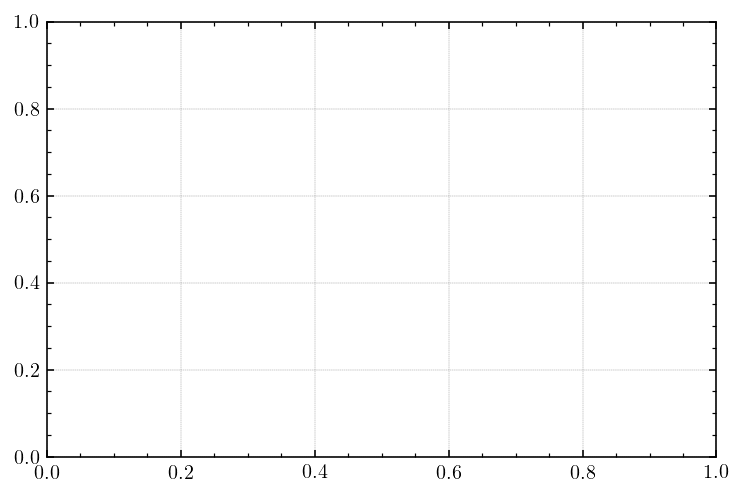

In [16]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
show_binary_bphase_map(ax, binary1, 0)
ax.legend()
ax.set_xlabel('b [au]')
ax.set_ylabel('true anomaly')
savefig(plt, 'binary-phase-a=100','.png','.png')

In [ ]:
#bs=['-128', '-64', '-32', '-16', '-8', '-4', '-2', '0', '2' , '4', '8', '16', '32', '64', '128']

bs=['-128', '-64', '-16', '-4', '0' , '4', '16', '64', '128']

a_idx=['0.5', '1', '2','4','8','16','32','64']

I = 0
fig = plt.figure(figsize=(1*len(a_idx), 1*len(bs)))
j=1
for b in bs:
    for a in a_idx:
        fname = prefix +'binary_' + b + '_' + a + '.txt'
        print(fname)
        binary = load_db_why_binary(fname,1)
        ax = fig.add_subplot(len(bs), len(a_idx), j)
        #if(j==1):
        #    ax.legend(fontsize=10)
            
        if( (j-1) % len(a_idx) == 0):
            ax.set_ylabel('$b=$ '+ b + ' au' )
        else:
            ax.set_yticklabels([])
    
            
        if(j > (len(a_idx) -1 ) * len(bs)):
            ax.set_xlabel('$a_s=$ ' + a + ' au')
        else:
            ax.set_xticklabels([])
        
        j+=1
        show_binary_phase_map(ax, binary, I)
        
plt.subplots_adjust(wspace=0, hspace=0)  
savefig(plt,'binary-phase','.png','.png')
#plt.tight_layout()

In [ ]:
binary1 = load_db_why_binary(prefix+ 'binary_b=10,a=1.txt',1)
show_binary_phase_map(binary1,np.pi)

In [ ]:
0.02739**(2.0/3)

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


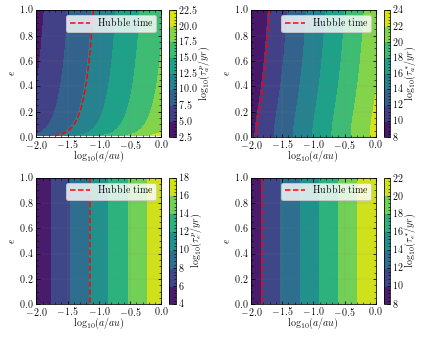

In [24]:
def draw_tidal_scale():
    km = 1 / 149597870.7
    rs = 6.957E5 * km
    rp = 69911 * km;
    ms = 1
    mp = 3.003E-6*317.8
    
    s = 9.0/4/1.5e9*mp/ms*rs**5
    
    p = 9.0/4/2.5e5*ms/mp*rp**5
    
    num = 100
    
    aa = 10**np.linspace(-2,0,num)*AU
    ee = np.linspace(0,1,num)
    
    a, e = np.meshgrid(aa, ee)
    
    n = np.sqrt( G*(ms+mp)/a**3)
    
    tap = 3/n*a**5/14/e**2/p
    
    tas = 3/n*a**5/s/(2*(2+46*e*e))
    
    ta = 1.5/n*a**5/((2+46*e*e)*s+7*e*e*p)
    
    tep = 3/n*a**5/7/p
    
    tes = 3/n*a**5/18/s
    
    te = 3/n*a**5/(18*s+7*p)
    
    fig = plt.figure(figsize=(3*2, 2.4*2))
    
    ax = fig.add_subplot(2,2,1)
    CS = ax.contourf(np.log10(aa),ee,np.log10(tap/YR))
    ax.contour(np.log10(aa),ee,np.log10(tap/YR),levels=[np.log10(Hubble_t/YR)],colors='r',linestyles='--')
    ax.plot([],[],label='Hubble time',ls='--',color='r')
    
    ax.set_xlabel('$\log_{10}(a/au)$')
    ax.set_ylabel('$e$')
    cbar = plt.colorbar(CS,ax=ax)
    cbar.set_label('$\log_{10}(\\tau_a^p/yr)$')
    ax.legend()
    
    ax = fig.add_subplot(2,2,2)
    CS = ax.contourf(np.log10(aa),ee,np.log10(tas/YR))
    ax.contour(np.log10(aa),ee,np.log10(tas/YR),levels=[np.log10(Hubble_t/YR)],colors='r',linestyles='--')
    ax.plot([],[],label='Hubble time',ls='--',color='r')
    
    ax.set_xlabel('$\log_{10}(a/au)$')
    ax.set_ylabel('$e$')
    cbar = plt.colorbar(CS,ax=ax)
    cbar.set_label('$\log_{10}(\\tau_a^*/yr)$')
    ax.legend()
    
    ax = fig.add_subplot(2,2,3)
    CS = ax.contourf(np.log10(aa),ee,np.log10(tep/YR))
    ax.contour(np.log10(aa),ee,np.log10(tep/YR),levels=[np.log10(Hubble_t/YR)],colors='r',linestyles='--')
    ax.plot([],[],label='Hubble time',ls='--',color='r')
    
    
    ax.set_xlabel('$\log_{10}(a/au)$')
    ax.set_ylabel('$e$')
    cbar = plt.colorbar(CS,ax=ax)
    cbar.set_label('$\log_{10}(\\tau_e^p/yr)$')
    ax.legend()
    
    ax = fig.add_subplot(2,2,4)
    CS = ax.contourf(np.log10(aa),ee,np.log10(tes/YR))
    ax.contour(np.log10(aa),ee,np.log10(tes/YR),levels=[np.log10(Hubble_t/YR)],colors='r',linestyles='--')
    ax.plot([],[],label='Hubble time',ls='--',color='r')
    
    
    ax.set_xlabel('$\log_{10}(a/au)$')
    ax.set_ylabel('$e$')
    cbar = plt.colorbar(CS,ax=ax)
    cbar.set_label('$\log_{10}(\\tau_e^*/yr)$')
    ax.legend()
    
    plt.tight_layout()
    savefig(plt,'tidal_time_2')
draw_tidal_scale()

In [8]:
def draw_ini(name, data):
    
    if 'stellar-orbit' in data['scattering'][0]:
        wide = 3
    else:
        wide = 2
    fig = plt.figure(figsize=(3.5*wide, 3))
    
    
    ax = fig.add_subplot(1, wide, 1)
        
        #print(data['scattering'][i])
    b = data['scattering'][0]['b']
    v = data['scattering'][0]['v_inf']
    draw_dist_2d(ax, b/AU, v/KMS, 'b/au', 'v/kms', '', 'b')
        
    ax = fig.add_subplot(1, wide, 2)
        
    w = data['scattering'][0]['w']
    ii = data['scattering'][0]['ii']
    draw_dist_2d(ax, w, np.cos(ii), '$\omega_i$', '$\cos(i_i)$', '', 'r')
    
    if 'stellar-orbit' in data['scattering'][0]:
        ax = fig.add_subplot(1, wide, wide)
        
        s_i = data['scattering'][0]['stellar-orbit']['i']
        s_omega = data['scattering'][0]['stellar-orbit']['Omega']
        draw_dist_2d(ax, s_omega, np.cos(s_i), '$\Omega$', '$\cos(i)$', '', 'g')
        
    plt.tight_layout()  
    #savefig(plt,name)

/home/yihan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


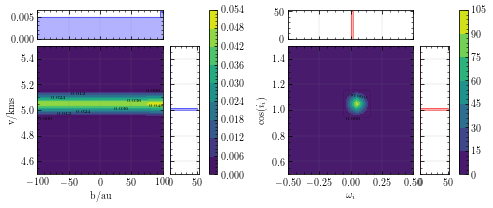

In [9]:
draw_ini('inits', single1)

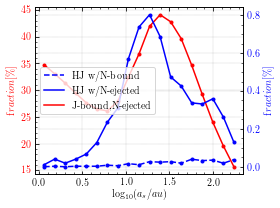

In [10]:
from scipy.interpolate import spline

def get_smooth(x,y):
    xnew = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
    ynew = spline(x,y,xnew)
    return xnew, ynew

def draw_ratios_spectrum(data):
    den = 20
    
    log_a_s = np.log10(data['scattering'][0]['stellar-orbit']['p'])
    
    x = np.linspace(log_a_s.min(), log_a_s.max(), den, endpoint = True)
    x_c = 0.5*(x[0:-1] + x[1::])
    bbs = []
    bes = []
    ebs = []
    ees = []
    hjs = []
    bbhjs=[]
    behjs=[]
    for i in range(len(x)-1):
        select = (x[i] <=log_a_s)&(log_a_s<x[i+1])
        
        b_b = data['scattering'][0]['b-b'][select].sum()
        b_e = data['scattering'][0]['b-e'][select].sum()
        e_b = data['scattering'][0]['e-b'][select].sum()
        e_e = data['scattering'][0]['e-e'][select].sum()
        
        hj = data['scattering'][0]['HJ'][select].sum()
        
        bbhj = (data['scattering'][0]['HJ']&data['scattering'][0]['b-b'])[select].sum()
        behj = (data['scattering'][0]['HJ']&data['scattering'][0]['b-e'])[select].sum()
        
        tot = b_b + b_e + e_b + e_e
        
        bbs.append((b_b/tot))
        bes.append((b_e/tot))
        ebs.append((e_b/tot))
        ees.append((e_e/tot))
        hjs.append(hj/tot)
        bbhjs.append(bbhj/tot)
        behjs.append(behj/tot)
    
    

    fig, ax1 = plt.subplots()
    #plt.plot(x_c,np.array(bbs),label='bb')
    ax1.plot(x_c,np.array(bes)*100,'r.',label='J-bound,N-ejected')
    ax1.plot(x_c,np.array(bes)*100,'r-')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_xlabel('$\log_{10}(a_s/au)$')
    
    ax1.set_ylabel('${\mathrm fraction [\%]}$',color='r')
    
    ax2 = ax1.twinx()
    #ax2.plot(x_c,np.array(hjs)*100,'b.',label='HJ')
    #ax2.plot(x_c,np.array(hjs)*100,'b-')
    
    ax2.plot(x_c,np.array(bbhjs)*100,'b.')
    ax2.plot(x_c,np.array(bbhjs)*100,'b--',label='HJ w/N-bound')
    
    ax2.plot(x_c,np.array(behjs)*100,'b.')
    ax2.plot(x_c,np.array(behjs)*100,'b-',label='HJ w/N-ejected')
    
    
    
    ax2.set_ylabel('${\mathrm fraction [\%]}$',color='b')
    
    ax2.plot([],[],'r-',label='J-bound,N-ejected')
    
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend()
    
    
    #plt.plot(x_c,np.array(ebs),label='eb')
    #plt.plot(x_c,np.array(ees),label='ee')
    #plt.yscale('log')
    fig.tight_layout()
    #savefig(plt,'a_spectrum')
    
draw_ratios_spectrum(binary)

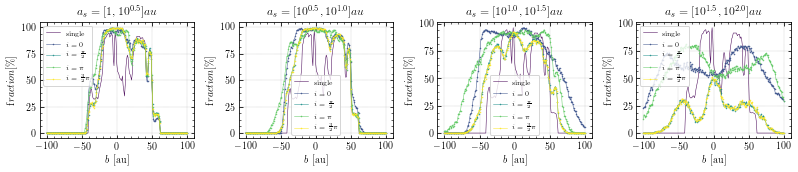

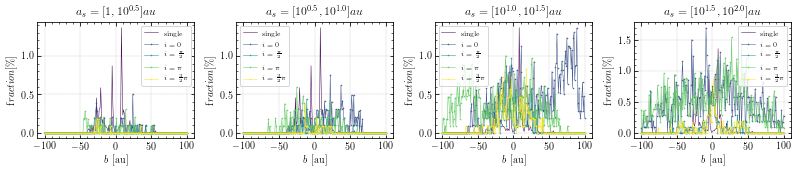

In [8]:
def get_b(re, m, v):
    return re*np.sqrt(1+2*G*m/re/v**2)

def draw_rates(name, single,binary,key):
    event_from_single = single['scattering'][0][key]
    event_from_binary = binary['scattering'][0][key]
    
    n_coll_single = ~(single['scattering'][0]['coll_js1']) #| single['scattering'][0]['coll_ns1'])
    n_coll_binary = ~(binary['scattering'][0]['coll_js1'] | binary['scattering'][0]['coll_js2']) #| binary['scattering'][0]['coll_ns2'])| binary['scattering'][0]['coll_ns1']
    
    b_single = single['scattering'][0]['b']
    b_binary = binary['scattering'][0]['b']
    
    incl = binary['scattering'][0]['stellar-orbit']['i']
    
    angle_0 = incl == 0
    angle_90 = np.abs(incl - 0.5*np.pi) < 0.1
    angle_180 = np.abs(incl - np.pi) <0.1
    angle_270 = np.abs(incl - 1.5*np.pi) < 0.1
    
    x = np.unique(b_single)
    
    #neptune_b = get_b(5,3, binary['scattering'][0]['v_inf'][0])
    #jupiter_b = get_b(1,3, binary['scattering'][0]['v_inf'][0])
    
    single_rates = np.array( [ ((b_single == xx)&(event_from_single)&(n_coll_single)).sum()/((b_single == xx)&(n_coll_single)).sum() for xx in x])*100
    
    
    a_s = binary['scattering'][0]['stellar-orbit']['p']
    
    a_slice = np.array([1, 10**0.5, 10, 10**1.5, 100])*AU
    a_label = ['$a_s=[1,10^{0.5}]au$','$a_s=[10^{0.5},10^{1.0}]au$','$a_s=[10^{1.0},10^{1.5}]au$','$a_s=[10^{1.5},10^{2.0}]au$']
    fig_wide = len(a_slice)-1
    
    import matplotlib.pylab as pl
    colors = pl.cm.viridis(np.linspace(0,1,5))
    
    fig = plt.figure(figsize=(2.8*fig_wide, 2.5))
    
    for i in range(len(a_slice)-1):
        ax = fig.add_subplot(1,fig_wide, i+1)
        
        as_min = a_slice[i]
        as_max = a_slice[i+1]
        select_a = (as_min<=a_s)&(a_s<as_max)
        
        tot = lambda a, b : (b_binary == a)& b &select_a& n_coll_binary
    
        binary_rates_0 = np.array( [ ((event_from_binary)&tot(xx, angle_0)).sum()/tot(xx, angle_0).sum() for xx in x])*100
        binary_rates_90 = np.array( [ ((event_from_binary)&tot(xx, angle_90)).sum()/tot(xx, angle_90).sum() for xx in x])*100
        binary_rates_180 = np.array( [ ((event_from_binary)&tot(xx, angle_180)).sum()/tot(xx, angle_180).sum() for xx in x])*100
        binary_rates_270 = np.array( [ ((event_from_binary)&tot(xx, angle_270)).sum()/tot(xx, angle_270).sum() for xx in x])*100
    
        ax.set_title(a_label[i])
        #ax.plot([],[],lw=0,label=a_label[i])
        ax.plot(x,single_rates,'-',label='single',color=colors[0],lw=0.5)
        ax.plot(x,binary_rates_0,'.-',label='$i=0$',color=colors[1],markersize=1,lw=0.5)
        ax.plot(x,binary_rates_90,'.-',label=r'$i=\frac{\pi}{2}$',color=colors[2],markersize=1,lw=0.5)
        ax.plot(x,binary_rates_180,'.-',label=r'$i=\pi$',color=colors[3],markersize=1,lw=0.5)
        ax.plot(x,binary_rates_270,'.-',label=r'$i=\frac{3}{2}\pi$',color=colors[4],markersize=1,lw=0.5)
        #ax.axvline(neptune_b,color='b',ls='--')
        #ax.axvline(-neptune_b,color='b',ls='--')
        #ax.axvline(jupiter_b,color='r',ls='--')
        #ax.axvline(-jupiter_b,color='r',ls='--')
        
        #ax.set_yscale('log')
        ax.legend(fontsize=7)
        ax.set_xlabel('$b$ [au]')
        ax.set_ylabel('${\mathrm fraction [\%]}$')
        
    plt.tight_layout()
    savefig(plt,name)   
#draw_rates('why_binary_re_e5',single5,binary5,'e-')

draw_rates('why_binary_e5',single5,binary5,'e-')

#draw_rates('why_binary_re_HJ5',single5,binary5,'HJ')

draw_rates('why_binary_HJ5',single5,binary5,'HJ')

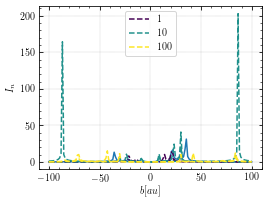

In [101]:
def get_re(b,v0,m):
    B=2*G*m/v0**2
    
    re = 0.5*( -B + np.sqrt(B**2 + 4*b*b))
    
    re[b<0]=-re[b<0]
    return re
    
def draw_I(binary,ideal_a):
    b = np.linspace(-100,100,150)
    v0 = binary['scattering'][0]['v_inf'][0]
    re = get_re(b, v0,1)
    re[b<0] = -re[b<0]
    
    ve = b/re*v0
    
    #print(re)
    v_j = np.sqrt(1)
    r_j = 1
    v_n = np.sqrt(1/6)
    r_n = 6
    
    I = lambda dp, dv : 1/np.abs(dp)/np.abs(dv)
    I_n = I(re+r_n, ve+v_n) + I(re-r_n,ve-v_n)
    I_j = I(re+r_j, ve+v_j) + I(re-r_j,ve-v_j)
    
    a_series = ideal_a#10**np.linspace(0,2,3,endpoint=True)
    #a_label =['1','10','100']
    I_n_max=[]
    I_n_min=[]
    I_j_max=[]
    I_j_min=[]
    for a in a_series:
        orbit_v = 0.5*np.sqrt(1.0/a)
        I_n_max.append( (I(re+r_n+0.5*a, ve+v_n+orbit_v) + I(re-r_n+0.5*a,ve-v_n+orbit_v))*0.5+(I(re+r_n-0.5*a, ve+v_n+orbit_v) + I(re-r_n-0.5*a,ve-v_n+orbit_v))*0.5)
        I_j_max.append((I(re+r_j+0.5*a, ve+v_j+orbit_v) + I(re-r_j+0.5*a,ve-v_j+orbit_v))*0.5+(I(re+r_j-0.5*a, ve+v_j+orbit_v) + I(re-r_j-0.5*a,ve-v_j+orbit_v))*0.5)
        I_n_min.append((I(re+r_n+0.5*a, ve+v_n-orbit_v) + I(re-r_n+0.5*a,ve-v_n-orbit_v))*0.5+(I(re+r_n-0.5*a, ve+v_n-orbit_v) + I(re-r_n-0.5*a,ve-v_n-orbit_v))*0.5)
        I_j_min.append((I(re+r_j+0.5*a, ve+v_j-orbit_v) + I(re-r_j+0.5*a,ve-v_j-orbit_v))*0.5+(I(re+r_j-0.5*a, ve+v_j-orbit_v) + I(re-r_j-0.5*a,ve-v_j-orbit_v))*0.5)
        
    
    fig= plt.figure(figsize=(4, 3))
    plt.plot(b,I_n)
    
    import matplotlib.pylab as pl
    colors = pl.cm.viridis(np.linspace(0,1,len(I_n_max)))
    
    for y_max, y_min,color,label in zip(I_n_max,I_n_min,colors,a_label):
        plt.plot(b,y_max,ls='--',color=color,label=label)
        plt.plot(b,y_min,ls='--',color=color)
        plt.legend()
        
    plt.xlabel('$b [au]$')
    plt.ylabel('$I_{n}$')
    #savefig(plt,'I_n')
draw_I(binary1)

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


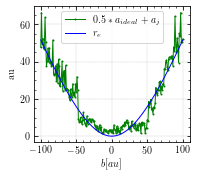

In [21]:
def draw_max_a(name,single,binary,key):
    
    n_coll_single = ~(single['scattering'][0]['coll_js1']) #| single['scattering'][0]['coll_ns1'])
    n_coll_binary = ~(binary['scattering'][0]['coll_js1']  | binary['scattering'][0]['coll_js2']) #| binary['scattering'][0]['coll_ns2']| binary['scattering'][0]['coll_ns1'])
    
    event_from_single = single['scattering'][0][key]
    event_from_binary = binary['scattering'][0][key]
    
    b_single = single['scattering'][0]['b']
    b_binary = binary['scattering'][0]['b']
    
    incl = binary['scattering'][0]['stellar-orbit']['i']
    
    angle_0 = incl == 0
    angle_90 = np.abs(incl - 0.5*np.pi) < 0.1
    angle_180 = np.abs(incl - np.pi) <0.1
    angle_270 = np.abs(incl - 1.5*np.pi) < 0.1
    
    x = np.unique(b_single)
    
    
    v0=binary['scattering'][0]['v_inf'][0]
    
    m=2
    
    B=2*G*m/v0**2
    
    xre = 0.5*( -B + np.sqrt(B**2 + 4*x*x))
    #xre[x<0]=-xre[x<0]
    
    log_a_s = np.log10(binary['scattering'][0]['stellar-orbit']['p'])
    
    ve = np.abs(binary['scattering'][0]['b'])*binary['scattering'][0]['v_inf']/binary['scattering'][0]['re']
    re = binary['scattering'][0]['re']
    
    a_bin_num = 'auto'
    
    v_j = np.sqrt(1)
    v_n = np.sqrt(1/1)
    r_n = 1
    
    ideal_a = []
    v_e = []
    dv =[]
    I = []
    I_p =[]
    I_m =[]
    for xx in x:
        select = (b_binary == xx)&event_from_binary&n_coll_binary
        
        hist, bin_edg = np.histogram(log_a_s[select], bins=a_bin_num,density = True)
        idx = np.where( hist == hist.max())[0][0]
        
        a_max = 0.5*(bin_edg[idx]+bin_edg[idx+1])
        
        ideal_a.append(a_max)
        dv.append(0.5*np.sqrt(1/a_max)/KMS)
        
        if(xx<0):
            v_e.append((ve[select][0] + v_n)/KMS)
            I.append(1/np.abs(-re[select][0] + r_n)**1/np.abs((ve[select][0] + v_n)) + 1/np.abs(-re[select][0] - r_n)**1/np.abs(ve[select][0] - v_n))
            #I_p.append(1/(-re[select][0] - (-6))**2/(ve[select][0] + v_n + 0.5*np.sqrt(1/a_max)))
            #I_m.append(1/(-re[select][0] - (-6))**2/(ve[select][0] + v_n - 0.5*np.sqrt(1/a_max)))
        else:
            v_e.append((ve[select][0] - v_n)/KMS)
            I.append(1/np.abs(re[select][0] - r_n)**1/np.abs((ve[select][0] - v_n)) + 1/np.abs(re[select][0] +r_n)**1/np.abs(ve[select][0] + v_n))
            #I_p.append(1/(re[select][0] - (6))**2/(ve[select][0] - v_n + 0.5*np.sqrt(1/a_max)))
            #I_m.append(1/(re[select][0] - (6))**2/(ve[select][0] - v_n - 0.5*np.sqrt(1/a_max)))
        
        
        
        
        
        
    #print(x,np.array(ideal_a))
    #plt.plot(x,np.array(v_e))
    #plt.plot(x,np.array(v_e)+np.array(dv),'--')
    #plt.plot(x,np.array(v_e)-np.array(dv),'--')
    
    #plt.plot(x,np.abs(np.array(I)))
    #plt.plot(x,np.array(I_p),'--')
    #plt.plot(x,np.array(I_m),'--')
    #plt.yscale('symlog')
    fig= plt.figure(figsize=(2.8, 2.5))
    
    #plt.plot(x,10**np.array(ideal_a),'r.-')
    plt.plot(x, 10**np.array(ideal_a)*0.5+1,'g.-',label='$0.5*a_{ideal}+a_j$',markersize=2,lw=1)
    plt.plot(x,xre,'b-',label='$r_e$',lw=1)
 
    plt.xlabel('$b[au]$')
    #plt.ylabel('$a_{ideal} [au]$')
    plt.ylabel('au')
    plt.legend()
    savefig(plt,name)
    
    return 10**np.array(ideal_a)
ideal_a = draw_max_a('ideal_a_e5',single5, binary5,'e-')


/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


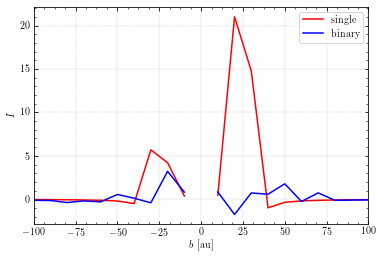

In [121]:
def draw_ieal_v_range(name,binary, ideal_a, aj):
    b = np.linspace(-100,100,len(ideal_a))
    
    v0 = binary['scattering'][0]['v_inf'][0]
    re = get_re(b, v0,1)
    re[b<0] = -re[b<0]
    
    ve = b/re*v0
    
    v_j = np.sqrt(1.0/aj)
    
    orbit_v = 0.5*np.sqrt(1.0/ideal_a)
    
    v_max = (ve+orbit_v)
    v_min = (ve-orbit_v)
    I = 1/np.abs(re - aj)/(ve-v_j) + 1/np.abs(re + aj)/(ve+v_j)
    da = 0.5*ideal_a
    
    I_max = 0.5*(1/np.abs(re - aj + da)/(v_max-v_j) + 1/np.abs(re + aj + da)/(v_max+v_j) + 1/np.abs(re - aj - da)/(v_min-v_j) + 1/np.abs(re + aj -da)/(v_min+v_j))
    
    #I_min = 1/np.abs(re - aj)/v_min + 1/np.abs(re + aj)/v_min
    
    #plt.plot(b,ve/KMS,'r',label='CoM $v_e$')
    
    
    #plt.axhline(v_j/KMS, ls='--',color='orange',label='$v_j$')
    
    
    #plt.fill_between(b,  v_max/KMS, v_min/KMS,alpha=0.3,color='green',label='$a_{ ideal}$')
    
    plt.plot(b,I,'r',label='single')
    plt.plot(b,I_max[::-1],'b',label='binary')
    #plt.fill_between(b,  I_max, I_min,alpha=0.3,color='green',label='$a_{ ideal}$')
        
    #plt.yscale('log')
    #plt.ylim([1,1000])
    plt.xlim([-100,100])
    plt.legend()
    #plt.ylabel('$v$ [kms]')
    plt.ylabel('$I$ ')
    plt.xlabel('$b$ [au]')
    savefig(plt,name)
    
draw_ieal_v_range('I_HJ5',binary5, ideal_a,5)

[   1.            3.16227766   10.           31.6227766   100.        ]


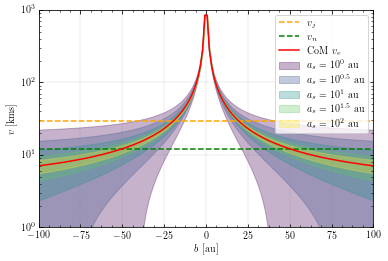

In [138]:
def draw_v_range(binary):
    b = np.linspace(-100,100,150)
    v0 = binary['scattering'][0]['v_inf'][0]
    re = get_re(b, v0,1)
    re[b<0] = -re[b<0]
    
    ve = b/re*v0
    
    a_series = 10**np.linspace(0,2,5,endpoint=True)
    print(a_series)
    a_label =['$a_s=10^{0}$ au','$a_s=10^{0.5}$ au','$a_s=10^{1}$ au','$a_s=10^{1.5}$ au','$a_s=10^{2}$ au']
    import matplotlib.pylab as pl
    colors = pl.cm.viridis(np.linspace(0,1,len(a_series)))
    
    v_j = np.sqrt(1.0/1)
    v_n = np.sqrt(1.0/6)
    
    plt.axhline(v_j/KMS, ls='--',color='orange',label='$v_j$')
    plt.axhline(v_n/KMS, ls='--',color='g',label='$v_n$')
    
    #plt.axhspan(v_j/KMS, -v_j/KMS, alpha=0.2, color='orange')
    
    #plt.axhspan(v_n/KMS, -v_n/KMS, alpha=0.2, color='blue')
    
    plt.plot(b,ve/KMS,'r',label='CoM $v_e$')
    for a,color,label in zip(a_series,colors,a_label):
        orbit_v = 0.5*np.sqrt(1.0/a)
        plt.fill_between(b,  (ve+orbit_v)/KMS, (ve-orbit_v)/KMS, color=color, label=label,alpha=0.3)
    
    plt.yscale('log')
    plt.ylim([1,1000])
    plt.xlim([-100,100])
    plt.legend()
    plt.ylabel('$v$ [kms]')
    plt.xlabel('$b$ [au]')
    savefig(plt,'v_range')
draw_v_range(binary)        

[ 100.           31.6227766    10.            3.16227766    1.        ]


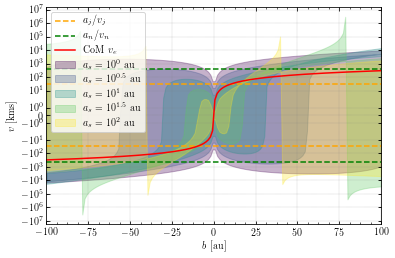

In [186]:
def draw_prod_range(binary):
    b = np.linspace(-100,100,150)
    v0 = binary['scattering'][0]['v_inf'][0]
    re = get_re(b, v0,1)
    re[b<0] = -re[b<0]
    
    ve = b/re*v0
    
    a_series = 10**np.linspace(2,0,5,endpoint=True)
    print(a_series)
    a_label =['$a_s=10^{0}$ au','$a_s=10^{0.5}$ au','$a_s=10^{1}$ au','$a_s=10^{1.5}$ au','$a_s=10^{2}$ au']
    import matplotlib.pylab as pl
    colors = pl.cm.viridis(np.linspace(0,1,len(a_series)))
    
    v_j = np.sqrt(1.0/1)
    v_n = np.sqrt(1.0/6)
    
    plt.axhline(1/v_j/KMS, ls='--',color='orange',label='$a_j / v_j$')
    plt.axhline(6/v_n/KMS, ls='--',color='g',label='$a_n / v_n$')
    
    plt.axhline(-1/v_j/KMS, ls='--',color='orange')
    plt.axhline(-6/v_n/KMS, ls='--',color='g')
    
    #plt.axhspan(v_j/KMS, -v_j/KMS, alpha=0.2, color='orange')
    
    #plt.axhspan(v_n/KMS, -v_n/KMS, alpha=0.2, color='blue')
    
    plt.plot(b,re*ve/KMS,'r',label='CoM $v_e$')
    for a,color,label in zip(a_series,colors,a_label):
        orbit_v = 0.5*np.sqrt(1.0/a)
        orbit_a = 0.5*a
        plt.fill_between(b,  (re+orbit_a)/(ve+orbit_v)/KMS, (re-orbit_a)/(ve-orbit_v)/KMS, color=color, label=label,alpha=0.3)
    
    plt.yscale('symlog')
    #plt.ylim([1,1000])
    plt.xlim([-100,100])
    plt.legend()
    plt.ylabel('$v$ [kms]')
    plt.xlabel('$b$ [au]')
    savefig(plt,'prod_range')
draw_prod_range(binary)        

[ 100.           31.6227766    10.            3.16227766    1.        ]


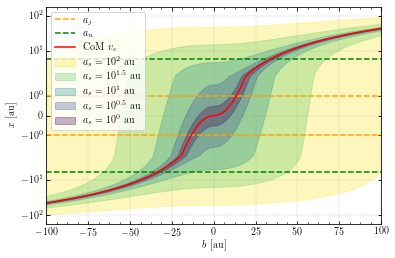

In [164]:
def draw_p_range(binary):
    b = np.linspace(-100,100,500)
    v0 = binary['scattering'][0]['v_inf'][0]
    re = get_re(b, v0,1)
    re[b<0] = -re[b<0]
    
    ve = b/re*v0
    
    a_series = 10**np.linspace(2,0,5,endpoint=True)
    print(a_series)
    a_label =['$a_s=10^{2}$ au','$a_s=10^{1.5}$ au','$a_s=10^{1}$ au','$a_s=10^{0.5}$ au','$a_s=10^{0}$ au']
    import matplotlib.pylab as pl
    colors = pl.cm.viridis(np.linspace(1,0,len(a_series)))
    
    
    
    plt.axhline(1, ls='--',color='orange',label='$a_j$')
    plt.axhline(6, ls='--',color='g',label='$a_n$')
    
    plt.axhline(-1, ls='--',color='orange')
    plt.axhline(-6, ls='--',color='g')
    
    #plt.axhspan(v_j/KMS, -v_j/KMS, alpha=0.2, color='orange')
    
    #plt.axhspan(v_n/KMS, -v_n/KMS, alpha=0.2, color='blue')
    
    plt.plot(b,re/AU,'r',label='CoM $v_e$')
    for a,color,label in zip(a_series,colors,a_label):
        orbit_a = 0.5*a
        #plt.plot(b, (re-orbit_a)/AU, color=color, label=label,ls='--')
        #plt.plot(b,(re+orbit_a)/AU, color=color,ls='--')
        plt.fill_between(b,  (re-orbit_a)/AU, (re+orbit_a)/AU, color=color, label=label,alpha=0.3)
    
    plt.yscale('symlog')
    plt.xlim([-100,100])
    plt.legend()
    plt.ylabel('$x$ [au]')
    plt.xlabel('$b$ [au]')
    savefig(plt,'x_range')
draw_p_range(binary)        

In [57]:
def draw_fraction(name, data, xkey, ykey,selected=[1,1,1,1]):
    wide = np.array(selected).sum()
    fig = plt.figure(figsize=(3.5*wide, 3))
    
        
    Tap = data['scattering'][0]['tap']
    Tas = data['scattering'][0]['tas']
        
    aj = data['scattering'][0]['a_j']
    ej = data['scattering'][0]['e_j']
    pj = aj*(1-ej)*(1-ej)
    #print(aj,ej)    
    bound_j = (aj>0)&(0 <=ej)&(ej<1)
    ubound_j = (ej >= 1)&(aj<0)
        
    an = data['scattering'][0]['a_n']
    en = data['scattering'][0]['e_n']
    pn = an*(1-en)*(1-en)
    #print(an,en)
    bound_n = (an>0)&(0 <=en)&(en<1)
    ubound_n = (en >= 1)&(an<0)
        
    state = [bound_j&bound_n, bound_j&ubound_n, ubound_j&bound_n, ubound_j&ubound_n]
    statel= ['Jupiter bound\n Neptune bound', 'Jupiter bound\n Neptune ejected', 'Jupiter ejected\n Neptune bound', 'Jupiter ejected\n Neptune ejected']
    colors =['g','r','b','purple']
        
    x = xkey[2](data['scattering'][0][xkey[0]]/xkey[1])
    y = ykey[2](data['scattering'][0][ykey[0]]/ykey[1])
            
    counter = 1
    for j, s, l, c in zip(selected, state, statel, colors):
        if j == 1:
            ax = fig.add_subplot(1, wide, counter)
            draw_dist_2d(ax, x[s], y[s], xkey[3], ykey[3], '', c)
            ax.plot([],[],lw=0,label=l)
            ax.legend(fontsize=8)
            counter+=1
    
    plt.tight_layout() 
    savefig(plt,name)